In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import datetime
from tensorflow_addons.optimizers import AdamW

In [2]:
# bin/python -m pip install tensorflow-addons

In [3]:
target = "Yield_Mg_ha"

In [4]:
df_trait = pd.read_csv("./1_trait_cleaned.csv")
def group_env_hybrid(df):
    res_row = df.iloc[0]
    res_row[target] = df[target].mean()
    return res_row


In [5]:
with pd.option_context("display.max_columns", None):
    display(df_trait)

,Env,Year,Field_Location,Experiment,Replicate,Block,Plot,Range,Pass,Hybrid,Hybrid_orig_name,Hybrid_Parent1,Hybrid_Parent2,Plot_Area_ha,Date_Planted,Date_Harvested,Stand_Count_plants,Pollen_DAP_days,Silk_DAP_days,Plant_Height_cm,Ear_Height_cm,Root_Lodging_plants,Stalk_Lodging_plants,Yield_Mg_ha,Grain_Moisture,Twt_kg_m3,not_discard
0,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,1,1.0,1.0,M0088/LH185,M0088/LH185,M0088,LH185,0.000716,125.0,272.0,56.0,63.0,67.0,213.00,79.00,0.0,0.0,5.721725,20.8,706.664693,True
1,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,2,1.0,2.0,M0143/LH185,M0143/LH185,M0143,LH185,0.000716,125.0,272.0,54.0,61.0,63.0,286.00,172.00,0.0,0.0,11.338246,25.8,693.792841,False
2,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,3,1.0,3.0,M0003/LH185,M0003/LH185,M0003,LH185,0.000716,125.0,272.0,60.0,63.0,65.0,239.00,92.00,0.0,4.0,6.540810,20.8,698.941582,True
3,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,4,1.0,4.0,M0035/LH185,M0035/LH185,M0035,LH185,0.000716,125.0,272.0,59.0,61.0,63.0,242.00,118.00,0.0,0.0,10.366857,23.7,711.813434,False
4,DEH1_2014,2014,DEH1,G2F_2014_15,1,1,5,1.0,5.0,M0052/LH185,M0052/LH185,M0052,LH185,0.000716,125.0,272.0,58.0,63.0,65.0,211.00,92.00,0.0,0.0,10.908814,19.4,743.993065,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128162,WIH3_2021,2021,WIH3,G2F_2020_21_PHP02,2,25,496,19.0,9.0,W10004_0101/PHP02,W10004_0101/PHP02,W10004_0101,PHP02,0.000929,119.0,278.0,80.0,75.0,76.0,251.67,123.33,NaN,NaN,9.972527,16.9,698.941582,True
128163,WIH3_2021,2021,WIH3,G2F_2020_21_PHP02,2,25,497,19.0,8.0,B37/H95,B37/H95,B37,H95,0.000929,119.0,278.0,65.0,81.0,90.0,303.33,148.33,1.0,NaN,9.160941,23.7,709.239064,True
128164,WIH3_2021,2021,WIH3,G2F_2020_21_PHP02,2,25,498,19.0,7.0,W10004_0501/PHP02,W10004_0501/PHP02,W10004_0501,PHP02,0.000929,119.0,278.0,69.0,76.0,79.0,301.67,150.00,NaN,NaN,9.256348,19.5,732.408398,True
128165,WIH3_2021,2021,WIH3,G2F_2020_21_PHP02,2,25,499,19.0,6.0,W10004_0409/PHP02,W10004_0409/PHP02,W10004_0409,PHP02,0.000929,119.0,278.0,81.0,78.0,79.0,293.33,165.00,1.0,5.0,11.504058,19.1,692.505656,True


In [6]:
df_meta = pd.read_csv("./2_meta_cleaned.csv")

In [7]:
df_soil = pd.read_csv("./3_soil_cleaned.csv")

In [10]:
df_weather_full = pd.read_csv("./4_weather_full.csv")
df_weather_average = pd.read_csv("./4_weather_averaged.csv")

In [11]:
df_strain_1 = pd.read_csv("./parent_1_mutations_pv.csv")
df_strain_2 = pd.read_csv("./parent_2_mutations_pv.csv")

In [12]:
df_strain_1 = df_strain_1.transpose()
df_strain_1.columns = [f"parent_1_mut_{i}" for i in range(df_strain_1.shape[1])]
df_strain_1 = df_strain_1.reset_index().rename({"index": "strain"}, axis=1)
df_strain_2 = df_strain_2.transpose()
df_strain_2.columns = [f"parent_2_mut_{i}" for i in range(df_strain_2.shape[1])]
df_strain_2 = df_strain_2.reset_index().rename({"index": "strain"}, axis=1)

In [13]:
df_strain = pd.read_csv("./strain.csv")

In [14]:
df_ec = pd.read_csv("./6_ec_cleaned.csv")

In [15]:
df_elevation = pd.read_csv("./G2F_Elevation.csv")

In [16]:
df_elevation["Elevation"] = df_elevation["Elevation(m)"]

In [17]:
df_field = df_trait[["Env", "Year", "Hybrid_Parent1", "Hybrid_Parent2", target] + \
                   ['Date_Planted', 'Date_Harvested',
                    'Stand_Count_plants', 'Pollen_DAP_days', 'Silk_DAP_days',
                    'Plant_Height_cm', 'Ear_Height_cm', 'Grain_Moisture', 'Twt_kg_m3']]\
    .merge(df_meta, on=["Env", "Year"])\
    .merge(df_soil, on=["Env", "Year"])\
    .merge(df_elevation[["Env", "Year", "Elevation"]], on=["Env", "Year"])
df_field.shape


(123311, 42)

In [18]:
set(df_trait['Env']) - set(df_elevation['Env'])

{'TXH4_2019'}

In [19]:
df_field = df_field.merge(df_ec, on=["Env", "Year"], how="left")
for colname in df_ec.columns:
    if colname in ["Env", "Year"]:
        continue
    df_field[colname] = df_field[colname].fillna(df_field[colname].mean())

In [20]:
df_trait[["Env", "Year", "Hybrid_Parent1", "Hybrid_Parent2", target]].shape

(128167, 5)

In [21]:
df_trait[["Env", "Year", "Hybrid_Parent1", "Hybrid_Parent2", target]]\
    .merge(df_meta, on=["Env", "Year"]).shape

(124021, 8)

In [22]:
df_trait[["Env", "Year", "Hybrid_Parent1", "Hybrid_Parent2", target]]\
    .merge(df_meta, on=["Env", "Year"])\
    .merge(df_soil, on=["Env", "Year"]).shape

(124021, 32)

In [23]:
df_field.shape

(123311, 73)

In [27]:
# let's just drop them for now
df_field = df_field.loc[~df_field.isna().any(axis=1)]
df_field.shape

(99779, 73)

In [28]:
df_hybrid = df_field\
    .merge(df_strain_1, left_on="Hybrid_Parent1", right_on="strain", how="left")\
    .merge(df_strain_2, left_on="Hybrid_Parent2", right_on="strain", how="left", suffixes=('_1', '_2'))\
    .drop("strain_1", axis=1)\
    .drop("strain_2", axis=1)\
    .fillna(0)
df_hybrid.shape


(99779, 383)

In [29]:
df_hybrid = df_hybrid\
    .merge(df_strain, left_on="Hybrid_Parent1", right_on="strain", how="left")\
    .merge(df_strain, left_on="Hybrid_Parent2", right_on="strain", how="left", suffixes=('_1', '_2'))\
    .drop("strain_1", axis=1)\
    .drop("strain_2", axis=1)\
#     .fillna(0)
df_hybrid.shape

(99779, 483)

In [30]:
for parent in [1, 2]:
    for col_id in range(1, 51):
        colname = f"V{col_id}_{parent}"
        df_hybrid[colname] = df_hybrid[colname].fillna(df_hybrid[colname].mean())

In [31]:
df_hybrid.isna().sum().sum()

0

In [34]:
df_hybrid["Loc"] = df_hybrid["Env"].map(lambda s: s.split('_')[0])
mean_average_train = df_hybrid.loc[df_hybrid["Year"] < 2021].groupby("Loc")[target].mean()
total_mean = df_hybrid.loc[df_hybrid["Year"] < 2021][target].mean()
df_hybrid["hint_average"] = df_hybrid["Loc"].map(mean_average_train).fillna(total_mean)
mean_by_env = df_hybrid.groupby("Env")[target].mean()
df_hybrid["hint_gt_average"] = df_hybrid["Env"].map(mean_by_env)


In [36]:
df_train = df_hybrid.loc[df_hybrid["Year"] < 2021].reset_index(drop=True)
df_val = df_hybrid.loc[df_hybrid["Year"] == 2021].reset_index(drop=True)
df_train.shape[0], df_val.shape[0]

(81155, 18624)

In [37]:
val_locs = list(set(df_val["Env"].map(lambda s: '_'.join(s.split('_')[:-1]))))
valtest_locs, valtrain_locs  = train_test_split(val_locs, test_size=0.5, random_state=2007)
df_valtrain = df_val.loc[df_val["Env"].map(lambda s: '_'.join(s.split('_')[:-1])).isin(valtrain_locs)].reset_index(drop=True)
df_valtest = df_val.loc[df_val["Env"].map(lambda s: '_'.join(s.split('_')[:-1])).isin(valtest_locs)].reset_index(drop=True)
df_valtrain.shape[0], df_valtest.shape[0]

(8465, 10159)

In [38]:
with pd.option_context("display.max_columns", None):
    display(df_train.head())

,Env,Year,Hybrid_Parent1,Hybrid_Parent2,Yield_Mg_ha,Date_Planted,Date_Harvested,Stand_Count_plants,Pollen_DAP_days,Silk_DAP_days,Plant_Height_cm,Ear_Height_cm,Grain_Moisture,Twt_kg_m3,Previous_Crop,City,Treatment,E Depth,1:1 Soil pH,WDRF Buffer pH,1:1 S Salts mmho/cm,Texture No,Organic Matter LOI %,Nitrate-N ppm N,lbs N/A,Potassium ppm K,Sulfate-S ppm S,Calcium ppm Ca,Magnesium ppm Mg,Sodium ppm Na,CEC/Sum of Cations me/100g,%H Sat,%K Sat,%Ca Sat,%Mg Sat,%Na Sat,Mehlich P-III ppm P,% Sand,% Silt,% Clay,Texture,Elevation,SDR_pGerEme,SDR_pEmeEnJ+pEnJFlo,SDR_pFloFla+pFlaFlw,SDR_pFlwStG,SDR_pStGEnG,TT_pGerEme,TT_pEmeEnJ+pEnJFlo,TT_pFloFla+pFlaFlw,TT_pFlwStG,TT_pStGEnG,yield_pFloFla+pFlaFlw,yield_pFlwStG,yield_pStGEnG,Eo_pFloFla+pFlaFlw,Eo_pFlwStG,Eo_pStGEnG,ESW_pFloFla+pFlaFlw,ESW_pFlwStG,ESW_pStGEnG,FlowNO3_pFloFla+pFlaFlw,FlowNO3_pFlwStG,PAWmm_pFloFla+pFlaFlw,PAWmm_pFlwStG,PAWmm_pStGEnG,LAI_pEmeEnJ+pEnJFlo,LAI_pFloFla+pFlaFlw,AccumulatedTT_pGerEme,AccumulatedTT_pEmeEnJ+pEnJFlo,AccumulatedTT_pFloFla+pFlaFlw,AccumulatedTT_pFlwStG,AccumulatedTT_pStGEnG,parent_1_mut_0,parent_1_mut_1,parent_1_mut_2,parent_1_mut_3,parent_1_mut_4,parent_1_mut_5,parent_1_mut_6,parent_1_mut_7,parent_1_mut_8,parent_1_mut_9,parent_1_mut_10,parent_1_mut_11,parent_1_mut_12,parent_1_mut_13,parent_1_mut_14,parent_1_mut_15,parent_1_mut_16,parent_1_mut_17,parent_1_mut_18,parent_1_mut_19,parent_1_mut_20,parent_1_mut_21,parent_1_mut_22,parent_1_mut_23,parent_1_mut_24,parent_1_mut_25,parent_1_mut_26,parent_1_mut_27,parent_1_mut_28,parent_1_mut_29,parent_1_mut_30,parent_1_mut_31,parent_1_mut_32,parent_1_mut_33,parent_1_mut_34,parent_1_mut_35,parent_1_mut_36,parent_1_mut_37,parent_1_mut_38,parent_1_mut_39,parent_1_mut_40,parent_1_mut_41,parent_1_mut_42,parent_1_mut_43,parent_1_mut_44,parent_1_mut_45,parent_1_mut_46,parent_1_mut_47,parent_1_mut_48,parent_1_mut_49,parent_1_mut_50,parent_1_mut_51,parent_1_mut_52,parent_1_mut_53,parent_1_mut_54,parent_1_mut_55,parent_1_mut_56,parent_1_mut_57,parent_1_mut_58,parent_1_mut_59,parent_1_mut_60,parent_1_mut_61,parent_1_mut_62,parent_1_mut_63,parent_1_mut_64,parent_1_mut_65,parent_1_mut_66,parent_1_mut_67,parent_1_mut_68,parent_1_mut_69,parent_1_mut_70,parent_1_mut_71,parent_1_mut_72,parent_1_mut_73,parent_1_mut_74,parent_1_mut_75,parent_1_mut_76,parent_1_mut_77,parent_1_mut_78,parent_1_mut_79,parent_1_mut_80,parent_1_mut_81,parent_1_mut_82,parent_1_mut_83,parent_1_mut_84,parent_1_mut_85,parent_1_mut_86,parent_1_mut_87,parent_1_mut_88,parent_1_mut_89,parent_1_mut_90,parent_1_mut_91,parent_1_mut_92,parent_1_mut_93,parent_1_mut_94,parent_1_mut_95,parent_1_mut_96,parent_1_mut_97,parent_1_mut_98,parent_1_mut_99,parent_1_mut_100,parent_1_mut_101,parent_1_mut_102,parent_1_mut_103,parent_1_mut_104,parent_1_mut_105,parent_1_mut_106,parent_1_mut_107,parent_1_mut_108,parent_1_mut_109,parent_1_mut_110,parent_1_mut_111,parent_1_mut_112,parent_1_mut_113,parent_1_mut_114,parent_1_mut_115,parent_1_mut_116,parent_1_mut_117,parent_1_mut_118,parent_1_mut_119,parent_1_mut_120,parent_1_mut_121,parent_1_mut_122,parent_1_mut_123,parent_1_mut_124,parent_1_mut_125,parent_1_mut_126,parent_1_mut_127,parent_1_mut_128,parent_1_mut_129,parent_1_mut_130,parent_1_mut_131,parent_1_mut_132,parent_1_mut_133,parent_1_mut_134,parent_1_mut_135,parent_1_mut_136,parent_1_mut_137,parent_1_mut_138,parent_1_mut_139,parent_1_mut_140,parent_1_mut_141,parent_1_mut_142,parent_1_mut_143,parent_1_mut_144,parent_1_mut_145,parent_1_mut_146,parent_1_mut_147,parent_1_mut_148,parent_1_mut_149,parent_1_mut_150,parent_1_mut_151,parent_1_mut_152,parent_1_mut_153,parent_1_mut_154,parent_1_mut_155,parent_1_mut_156,parent_1_mut_157,parent_1_mut_158,parent_1_mut_159,parent_1_mut_160,parent_1_mut_161,parent_1_mut_162,parent_1_mut_163,parent_1_mut_164,parent_1_mut_165,parent_1_mut_166,parent_1_mut_167,parent_1_mut_168,parent_1_mut_169,parent_1_mut_170,parent_1_mut_171,parent_1_mut_172,parent_1_mut_173,parent_1_mut_174,parent_1_mut_175,parent_1_mut_176,parent_1_mut_177,parent_1_mut_178,par

In [39]:
cat_features = ["Texture", "Previous_Crop", "City", "Loc", "Treatment"] 
trait_cols = ['Plant_Height_cm', 'Ear_Height_cm', 'Stand_Count_plants', 'Grain_Moisture', 'Twt_kg_m3', 'Pollen_DAP_days', 'Silk_DAP_days']
cols_to_predict = []

features_to_remove = set([
    "Env", "Hybrid_Parent1", "Hybrid_Parent2", target, "hint_average", "hint_gt_average", "hint_ec_available", "not_discard"
] + cat_features) | set(trait_cols) - set(cols_to_predict) # + [f"V{i}_{parent}" for i in range(10, 51) for parent in [1, 2]])
numerical_features = ["hint_average"] + [col for col in df_hybrid.columns if col not in features_to_remove]
numerical_features = list(numerical_features)

In [43]:
X_train = df_train[cat_features + numerical_features]
y_train = df_train[target]
X_valtrain = df_valtrain[cat_features + numerical_features]
y_valtrain = df_valtrain[target]
X_valtest = df_valtest[cat_features + numerical_features]
y_valtest = df_valtest[target]


X_val = df_val[cat_features + numerical_features]
y_val = df_val[target]


y_train_centered = y_train - df_train["hint_gt_average"]
y_valtrain_centered = y_valtrain - df_valtrain["hint_gt_average"]
y_valtest_centered = y_valtest - df_valtest["hint_gt_average"]

## NN

In [44]:
import tensorflow as tf

In [45]:
log_dir_t = "./logs/fit_cnn/"

In [46]:
cat_features_n = {colname: len(set(X_train[colname])) + 1 for colname in cat_features}
label_encoders = {
    colname: OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=cat_features_n[colname] - 1
    ).fit(X_train[[colname]]) for colname in cat_features
}


In [47]:
max_period_length = int(df_weather_full.groupby('Env').apply(lambda df: df.shape[0]).max())
max_period_length

212

In [48]:
df_weather_full_padded = df_weather_full.groupby('Env').apply(
    lambda df: pd.concat([df] + [df.iloc[[-1]] for i in range(max_period_length - df.shape[0])])
).reset_index(drop=True)

In [49]:
heat_cols = ['T2M_MIN', 'T2M', 'T2M_MAX', 'GDU_accum_norm']
drought_cols = ['PRECTOTCORR', 'VPD', 'WS2M', 'GDU_accum_norm']

In [50]:
train_weather_heat = []
train_weather_drought = []
for env in tqdm(df_train['Env']):
    train_weather_heat.append
    env_weather = df_weather_full_padded.loc[df_weather_full_padded['Env'] == env]
    train_weather_heat.append(env_weather[heat_cols].to_numpy())
    train_weather_drought.append(env_weather[drought_cols].to_numpy())
train_weather_heat = np.array(train_weather_heat)
train_weather_drought = np.array(train_weather_drought)

In [51]:
val_weather_heat = []
val_weather_drought = []
for env in tqdm(df_val['Env']):
    val_weather_heat.append
    env_weather = df_weather_full_padded.loc[df_weather_full_padded['Env'] == env]
    val_weather_heat.append(env_weather[heat_cols].to_numpy())
    val_weather_drought.append(env_weather[drought_cols].to_numpy())
val_weather_heat = np.array(val_weather_heat)
val_weather_drought = np.array(val_weather_drought)

In [52]:
ok_indices = [i  for i, t in enumerate(train_weather_heat) if t.shape[0] != 0]
X_train = X_train.iloc[ok_indices]
y_train  = y_train[ok_indices]
train_weather_heat = train_weather_heat[ok_indices]
train_weather_heat = np.concatenate(train_weather_heat).reshape(-1, 212, 4)
train_weather_drought = train_weather_drought[ok_indices]
train_weather_drought = np.concatenate(train_weather_drought).reshape(-1, 212, 4)
train_weather_heat.shape, train_weather_drought.shape

((79148, 212, 4), (79148, 212, 4))

In [53]:
ok_indices = [i  for i, t in enumerate(val_weather_heat) if t.shape[0] != 0]
X_val = X_val.iloc[ok_indices]
y_val  = y_val[ok_indices]
val_weather_heat = val_weather_heat[ok_indices]
val_weather_heat = np.concatenate(val_weather_heat).reshape(-1, 212, 4)
val_weather_drought = val_weather_drought[ok_indices]
val_weather_drought = np.concatenate(val_weather_drought).reshape(-1, 212, 4)
val_weather_heat.shape, val_weather_drought.shape

((18624, 212, 4), (18624, 212, 4))

In [54]:
y_train_centered = y_train - df_train.loc[X_train.index, "hint_gt_average"]
y_val_centered = y_val - df_val.loc[X_val.index, "hint_gt_average"]

In [55]:
scaler_heat = StandardScaler()
scaler_drought = StandardScaler()

In [56]:
scaler_heat.fit(
    df_weather_full.loc[df_weather_full["Env"].map(lambda s: int(s.split('_')[-1])) < 2021][heat_cols]
)
scaler_drought.fit(
    df_weather_full.loc[df_weather_full["Env"].map(lambda s: int(s.split('_')[-1])) < 2021][drought_cols]
)

StandardScaler()

In [57]:
train_weather_heat = np.array([scaler_heat.transform(t) for t in train_weather_heat])
train_weather_drought = np.array([scaler_drought.transform(t) for t in train_weather_drought])

In [58]:
val_weather_heat = np.array([scaler_heat.transform(t) for t in val_weather_heat])
val_weather_drought = np.array([scaler_drought.transform(t) for t in val_weather_drought])

In [59]:
df_soil_add = pd.read_csv("./Soil_all.csv")

In [61]:
env_to_aws = df_soil_add.set_index('Env')['aws_1m']

In [68]:
df_train['aws_1m'] = df_train['Env'].map(env_to_aws).fillna(df_soil_add['aws_1m'].median())
df_val['aws_1m'] = df_val['Env'].map(env_to_aws).fillna(df_soil_add['aws_1m'].median())

In [70]:
X_train['aws_1m'] = df_train['aws_1m'].loc[X_train.index]
X_val['aws_1m'] = df_val['aws_1m'].loc[X_val.index]

In [81]:
soil_cat_features = ['Texture', 'Previous_Crop', 'Treatment']
ec_cat_features = []
general_cat_features = ['Loc']

soil_numeric_features = [
#     'E Depth',
    '1:1 Soil pH',
#     'WDRF Buffer pH',
#     '1:1 S Salts mmho/cm',
#     'Texture No',
    'Organic Matter LOI %',
#     'Nitrate-N ppm N',
#     'lbs N/A',
#     'Potassium ppm K',
#     'Sulfate-S ppm S',
#     'Calcium ppm Ca',
#     'Magnesium ppm Mg',
#     'Sodium ppm Na',
    'CEC/Sum of Cations me/100g',
#     '%H Sat',
    '%K Sat',
#     '%Ca Sat',
#     '%Mg Sat',
#     '%Na Sat',
#     'Mehlich P-III ppm P',
    '% Sand',
    '% Silt',
    '% Clay',
    'aws_1m',
    'Elevation',
]

ec_numeric_features = [
    'SDR_pGerEme',
    'SDR_pEmeEnJ+pEnJFlo',
    'SDR_pFloFla+pFlaFlw',
    'SDR_pFlwStG',
    'SDR_pStGEnG',
    'TT_pGerEme',
    'TT_pEmeEnJ+pEnJFlo',
    'TT_pFloFla+pFlaFlw',
    'TT_pFlwStG',
    'TT_pStGEnG',
    'yield_pFloFla+pFlaFlw',
    'yield_pFlwStG',
    'yield_pStGEnG',
    'Eo_pFloFla+pFlaFlw',
    'Eo_pFlwStG',
    'Eo_pStGEnG',
    'ESW_pFloFla+pFlaFlw',
    'ESW_pFlwStG',
    'ESW_pStGEnG',
    'FlowNO3_pFloFla+pFlaFlw',
    'FlowNO3_pFlwStG',
    'PAWmm_pFloFla+pFlaFlw',
    'PAWmm_pFlwStG',
    'PAWmm_pStGEnG',
    'LAI_pEmeEnJ+pEnJFlo',
    'LAI_pFloFla+pFlaFlw',
    'AccumulatedTT_pGerEme',
    'AccumulatedTT_pEmeEnJ+pEnJFlo',
    'AccumulatedTT_pFloFla+pFlaFlw',
    'AccumulatedTT_pFlwStG',
    'AccumulatedTT_pStGEnG',
#     'Elevation',
]
general_numeric_features = ['hint_average']
hybrid_features = [
    f'V{i}_{parent}' for i in range(1, 51) for parent in [1, 2]
]

In [99]:
soil_cat_features_env = ['Texture', 'Previous_Crop', 'Treatment']
ec_cat_features_env = []
general_cat_features_env = ['Loc']

soil_numeric_features_env = [
    'E Depth',
    '1:1 Soil pH',
    'WDRF Buffer pH',
    '1:1 S Salts mmho/cm',
    'Texture No',
    'Organic Matter LOI %',
    'Nitrate-N ppm N',
    'lbs N/A',
    'Potassium ppm K',
    'Sulfate-S ppm S',
    'Calcium ppm Ca',
    'Magnesium ppm Mg',
    'Sodium ppm Na',
    'CEC/Sum of Cations me/100g',
    '%H Sat',
    '%K Sat',
    '%Ca Sat',
    '%Mg Sat',
    '%Na Sat',
    'Mehlich P-III ppm P',
    '% Sand',
    '% Silt',
    '% Clay',
    'aws_1m',
    'Elevation',
]

ec_numeric_features_env = [
    'SDR_pGerEme',
    'SDR_pEmeEnJ+pEnJFlo',
    'SDR_pFloFla+pFlaFlw',
    'SDR_pFlwStG',
    'SDR_pStGEnG',
    'TT_pGerEme',
    'TT_pEmeEnJ+pEnJFlo',
    'TT_pFloFla+pFlaFlw',
    'TT_pFlwStG',
    'TT_pStGEnG',
    'yield_pFloFla+pFlaFlw',
    'yield_pFlwStG',
    'yield_pStGEnG',
    'Eo_pFloFla+pFlaFlw',
    'Eo_pFlwStG',
    'Eo_pStGEnG',
    'ESW_pFloFla+pFlaFlw',
    'ESW_pFlwStG',
    'ESW_pStGEnG',
    'FlowNO3_pFloFla+pFlaFlw',
    'FlowNO3_pFlwStG',
    'PAWmm_pFloFla+pFlaFlw',
    'PAWmm_pFlwStG',
    'PAWmm_pStGEnG',
    'LAI_pEmeEnJ+pEnJFlo',
    'LAI_pFloFla+pFlaFlw',
    'AccumulatedTT_pGerEme',
    'AccumulatedTT_pEmeEnJ+pEnJFlo',
    'AccumulatedTT_pFloFla+pFlaFlw',
    'AccumulatedTT_pFlwStG',
    'AccumulatedTT_pStGEnG',
]
general_numeric_features_env = ['hint_average']
weather_features_env = sorted(df_weather_average.columns[2:-1], key=lambda s: int(s.split('_')[-1]))

In [101]:

env_to_train_count = df_train.loc[X_train.index]['Env'].value_counts()
loc_to_val_count = df_val.loc[X_val.index]['Loc'].value_counts()
df_train['weight'] = df_train.loc[X_train.index]['Env'].map(1 / env_to_train_count)
df_train['weight'] = df_train['weight'] / df_train['weight'].sum() * df_train['weight'].shape[0]
# df_train['weight'] = df_train.loc[X_train.index]['Loc'].map(loc_to_train_count).fillna(loc_to_train_count.min() / 2)
# df_train['weight'] = df_train.loc[X_train.index]['Loc'].map(loc_to_test_count).fillna(loc_to_test_count.min() / 2)
df_train_w = df_train.loc[X_train.index].merge(df_weather_average, on=['Env', 'Year'])
df_val_w = df_val.loc[X_val.index].merge(df_weather_average, on=['Env', 'Year'])
w_features = soil_cat_features_env \
    + ec_cat_features_env \
    + general_cat_features_env \
    + soil_numeric_features_env \
    + ec_numeric_features_env \
    + general_numeric_features_env \
    + weather_features_env
X_train_w = df_train_w[w_features].copy()
X_val_w = df_val_w[w_features].copy()
cat_features = soil_cat_features_env + ec_cat_features_env + general_cat_features_env + ['scenario']
num_features = list(set(X_train_w.columns) - set(cat_features))
scaler_num = StandardScaler()
scaler_num.fit(X_train_w[num_features])
X_train_w.loc[:, num_features] = scaler_num.transform(X_train_w[num_features])
X_val_w.loc[:, num_features] = scaler_num.transform(X_val_w[num_features])

In [102]:
X_train_soil = X_train[soil_numeric_features].to_numpy()
X_val_soil = X_val[soil_numeric_features].to_numpy()
scaler_soil = StandardScaler() 
scaler_soil.fit(X_train_soil)
X_train_soil = scaler_soil.transform(X_train_soil)
X_val_soil = scaler_soil.transform(X_val_soil)

In [103]:
X_train_ec = X_train[ec_numeric_features].to_numpy()
X_val_ec = X_val[ec_numeric_features].to_numpy()
scaler_ec = StandardScaler() 
scaler_ec.fit(X_train_ec)
X_train_ec = scaler_ec.transform(X_train_ec)
X_val_ec = scaler_ec.transform(X_val_ec)

In [104]:
X_train_general = X_train[general_numeric_features].to_numpy()
X_val_general = X_val[general_numeric_features].to_numpy()
scaler_general = StandardScaler() 
scaler_general.fit(X_train_general)
X_train_general = scaler_general.transform(X_train_general)
X_val_general = scaler_general.transform(X_val_general)

In [105]:
X_train_weather_average = X_train_w[weather_features_env].to_numpy()
X_val_weather_average = X_val_w[weather_features_env].to_numpy()
scaler_weather_average = StandardScaler() 
scaler_weather_average.fit(X_train_weather_average)
X_train_weather_average = scaler_weather_average.transform(X_train_weather_average)
X_val_weather_average = scaler_weather_average.transform(X_val_weather_average)

In [106]:
X_train_hybrid = X_train[hybrid_features].to_numpy()
X_val_hybrid = X_val[hybrid_features].to_numpy()
scaler_hybrid = StandardScaler()
scaler_hybrid.fit(df_strain.iloc[:, 1:].to_numpy())
n_hybrid_features = len(hybrid_features)
X_train_hybrid = np.hstack([
    scaler_hybrid.transform(X_train_hybrid[:, :n_hybrid_features//2]),
    scaler_hybrid.transform(X_train_hybrid[:, n_hybrid_features//2:]),
])
X_val_hybrid = np.hstack([
    scaler_hybrid.transform(X_val_hybrid[:, :n_hybrid_features//2]),
    scaler_hybrid.transform(X_val_hybrid[:, n_hybrid_features//2:]),
])

In [107]:
sub_numerical_features = [s for s in numerical_features if not s.startswith("parent")]

X_train_tf = {}
for colname in cat_features:
    if colname == 'scenario':
        continue
    X_train_tf[colname] = label_encoders[colname].transform(X_train[[colname]])
X_train_tf["soil_numeric"] = X_train_soil
X_train_tf["ec_numeric"] = X_train_ec
X_train_tf["general_numeric"] = X_train_general
X_train_tf["hybrid"] = X_train_hybrid
X_train_tf["weather_heat"] = train_weather_heat
X_train_tf["weather_drought"] = train_weather_drought
X_train_tf["weather_average"] = X_train_weather_average

X_val_tf = {}
for colname in cat_features:
    if colname == 'scenario':
        continue
    X_val_tf[colname] = label_encoders[colname].transform(X_val[[colname]])
X_val_tf["soil_numeric"] = X_val_soil
X_val_tf["ec_numeric"] = X_val_ec
X_val_tf["general_numeric"] = X_val_general
X_val_tf["hybrid"] = X_val_hybrid
X_val_tf["weather_heat"] = val_weather_heat
X_val_tf["weather_drought"] = val_weather_drought
X_val_tf["weather_average"] = X_val_weather_average

In [136]:
def create_nn_model(
    cat_features,
    numerical_features,
    network_layer_size_list,
    hybrid_network_layer_size_list,
    dropout_rate,
    hw_dropout_rate,
    inputs_dropout_rate,
    reg_coefs,
    embeddings_reg_coef,
    cnn_reg_coef,
    total_mean,
    total_range,
    batch_size=32,
    epochs =100,
    lr=1e-5,
):
    n_soil_numeric_features = len(soil_numeric_features)
    n_ec_numeric_features = len(ec_numeric_features)
    n_general_numeric_features = len(general_numeric_features)
    n_hybrid_features = len(hybrid_features)
    n_weather_heat_features = train_weather_heat[0].shape[1]
    n_weather_drought_features = train_weather_drought[0].shape[1]
    n_weather_average_features = len(weather_features_env)
    cat_input_layers = {}
    embedding_layers = {}
    embedding_dim = 1
    for colname in soil_cat_features + general_cat_features:
        n_levels = cat_features_n[colname]
        col_embedding_dim = 1#int((n_levels + 2) ** 0.5 * embedding_dim)
        cat_input_layers[colname] = tf.keras.layers.Input(shape=(1,))
        embedding_layers[colname] = tf.keras.layers.Embedding(
                input_dim=n_levels,
                output_dim=col_embedding_dim,
                embeddings_regularizer=tf.keras.regularizers.L2(l2=embeddings_reg_coef),
                name=f"embedding_{colname}",
        )
    soil_numeric_input_layer = tf.keras.layers.Input(shape=(n_soil_numeric_features,), name=f"soil_numeric_input")
    ec_numeric_input_layer = tf.keras.layers.Input(shape=(n_ec_numeric_features,), name=f"ec_numeric_input")
    general_numeric_input_layer = tf.keras.layers.Input(shape=(n_general_numeric_features,), name=f"general_numeric_input")
    hybrid_input_layer = tf.keras.layers.Input(shape=(n_hybrid_features,), name=f"hybrid_input")
    weather_heat_input_layer = tf.keras.layers.Input(shape=(max_period_length, n_weather_heat_features,), name=f"weather_heat_input")
    weather_drought_input_layer = tf.keras.layers.Input(shape=(max_period_length, n_weather_drought_features,), name=f"weather_drought_input")
    weather_average_input_layer = tf.keras.layers.Input(shape=(n_weather_average_features,), name=f"weather_average_input")

    weather_heat_cnn_layers = []
#     weather_heat_cnn_layers.append(tf.keras.layers.Dropout(dropout_rate))
#     weather_heat_cnn_layers.append(tf.keras.layers.BatchNormalization())
    weather_heat_cnn_layers.append(
        tf.keras.layers.Conv1D(
            filters=3,
            kernel_size=15,
            strides=11,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.L2(l2=cnn_reg_coef)
        )
    )
    weather_heat_cnn = tf.keras.Sequential(weather_heat_cnn_layers, name='weather_heat_cnn')
    
    weather_drought_cnn_layers = []
#     weather_drought_cnn_layers.append(tf.keras.layers.Dropout(dropout_rate))
#     weather_drought_cnn_layers.append(tf.keras.layers.BatchNormalization())
    weather_drought_cnn_layers.append(
        tf.keras.layers.Conv1D(
            filters=3,
            kernel_size=15,
            strides=11,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.L2(l2=cnn_reg_coef)
        )
    )
    weather_drought_cnn = tf.keras.Sequential(weather_drought_cnn_layers, name='weather_drought_cnn')    
    
    hybrid_network_layers = []
#     hybrid_network_layers.append(tf.keras.layers.Dropout(dropout_rate))
    for i, size in enumerate(hybrid_network_layer_size_list):
        reg = reg_coefs[0]
        hybrid_network_layers.append(tf.keras.layers.Dense(
            units=size,
            activation=None,
            kernel_regularizer=tf.keras.regularizers.L2(l2=reg)
        ))
        hybrid_network_layers.append(tf.keras.layers.ReLU())
        hybrid_network_layers.append(tf.keras.layers.Dropout(dropout_rate))
        hybrid_network_layers.append(tf.keras.layers.BatchNormalization())
    hybrid_network_layers.append(tf.keras.layers.Dense(
        units=18,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(l2=reg_coefs[0])
    ))
    hybrid_network = tf.keras.Sequential(hybrid_network_layers, name='hybrid_network')
    
    hybrid_weather_heat_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
        units=1,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(l2=reg_coefs[1])
    ), name='hybrid_weather_heat')
    hybrid_weather_drought_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
        units=1,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(l2=reg_coefs[1])
    ), name='hybrid_weather_drought')
    hybrid_weather_stress_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
        units=1,
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(l2=reg_coefs[1])
    ), name='hybrid_weather_stress')
    
    
    network_layers = []
#     network_layers.append(tf.keras.layers.BatchNormalization())
#     network_layers.append(tf.keras.layers.Dropout(0.1))
    for i, size in enumerate(network_layer_size_list):
        reg = reg_coefs[2]
        network_layers.append(tf.keras.layers.Dense(
            units=size,
            activation=None,
            kernel_regularizer=tf.keras.regularizers.L2(l2=reg)
        ))
        network_layers.append(tf.keras.layers.Dropout(dropout_rate))
        network_layers.append(tf.keras.layers.ReLU())
#         network_layers.append(tf.keras.layers.BatchNormalization())
    network_layers.append(tf.keras.layers.Dense(
        units=1,
        activation=None,
        activity_regularizer=tf.keras.regularizers.L2(l2=reg_coefs[3])
    ))
    network = tf.keras.Sequential(network_layers)

    soil_embeddings = []
    for colname in soil_cat_features:
        e, i = embedding_layers[colname], cat_input_layers[colname]
        soil_embeddings.append(tf.reshape(e(i), shape=[-1, e.output_shape[-1]]))
    general_embeddings = []
    for colname in general_cat_features:
        e, i = embedding_layers[colname], cat_input_layers[colname]
        general_embeddings.append(tf.reshape(e(i), shape=[-1, e.output_shape[-1]]))
    
    s = soil_embeddings
    s_n = soil_numeric_input_layer
    s += [s_n]
    s = tf.concat(s, axis=1)
    s = tf.reshape(
        tf.repeat(s, repeats=max_period_length, axis=0),
        (-1, max_period_length, s.shape[-1])
    )
    w_h = weather_heat_input_layer
    w_h = weather_heat_cnn(tf.concat([w_h, s], axis=-1))
    
    w_d = weather_drought_input_layer
    w_d = weather_drought_cnn(tf.concat([w_d, s], axis=-1))
    
    w_s = tf.reshape(weather_average_input_layer, shape=(-1, 18, 4))
    
    h = hybrid_input_layer
    h_n = hybrid_network(h)
    h_n = tf.reshape(h_n, shape=(-1, 18, 1))
    
    h_wh = hybrid_weather_heat_layer(tf.concat([h_n, w_h], axis=-1))
    h_wh = tf.squeeze(h_wh, axis=-1)
    h_wh = tf.keras.layers.Dropout(hw_dropout_rate)(h_wh)
    h_wd = hybrid_weather_drought_layer(tf.concat([h_n, w_d], axis=-1))
    h_wd = tf.squeeze(h_wd, axis=-1)
    h_wd = tf.keras.layers.Dropout(hw_dropout_rate)(h_wd)
    h_ws = hybrid_weather_stress_layer(tf.concat([h_n, w_s], axis=-1))
    h_ws = tf.squeeze(h_ws, axis=-1)
    h_ws = tf.keras.layers.Dropout(hw_dropout_rate)(h_ws)
    
    
    
    
#     g = general_embeddings
#     g_n = general_numeric_input_layer
    ec = ec_numeric_input_layer
#     network_inputs = tf.concat([ec, g_n] + g, axis=-1)
    network_inputs = tf.concat([ec], axis=-1)
    network_inputs = tf.keras.layers.Dropout(inputs_dropout_rate)(network_inputs)
    x = [h_wh, h_wd, h_ws, network_inputs]
    for c in x:
        print(c)
    x = tf.concat(x, axis=-1)
    
    o = network(x) + total_mean
    output = o
#     output = tf.keras.activations.sigmoid(o)
#     output = (
#         total_mean
#         + (output - 0.5) * 2 * total_range
#     )
    inputs = {colname: cat_input_layers[colname] for colname in soil_cat_features + general_cat_features}
    inputs["soil_numeric"] = soil_numeric_input_layer
    inputs["ec_numeric"] = ec_numeric_input_layer
    inputs["general_numeric"] = general_numeric_input_layer
    inputs["hybrid"] = hybrid_input_layer
    inputs["weather_heat"] = weather_heat_input_layer
    inputs["weather_drought"] = weather_drought_input_layer
    inputs["weather_average"] = weather_average_input_layer
    model = tf.keras.Model(
        inputs=inputs,
        outputs=output,
    )
    loss = tf.keras.losses.MeanSquaredError()
    total_steps = X_train.shape[0] // batch_size * epochs
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr, decay_steps=1237*60, decay_rate=0.5
    )

    model.compile(
        loss=loss,
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    return model




In [137]:
batch_size=64
epochs=300

log_dir = log_dir_t + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model = create_nn_model(
    cat_features=cat_features,
    numerical_features=numerical_features,
    network_layer_size_list=[200],
    hybrid_network_layer_size_list=[],
    dropout_rate=0.5,
    hw_dropout_rate=0.5,
    inputs_dropout_rate=0.5,
    reg_coefs=[0.01, 0.01, 0.01, 0.01],
    embeddings_reg_coef=0.01,
    cnn_reg_coef=0.01,
    total_mean=0,
    total_range=30,
    batch_size=batch_size,
    epochs=epochs,
    lr=3e-4
)


Tensor("dropout_29/cond/Identity:0", shape=(None, 18), dtype=float32)
Tensor("dropout_30/cond/Identity:0", shape=(None, 18), dtype=float32)
Tensor("dropout_31/cond/Identity:0", shape=(None, 18), dtype=float32)
Tensor("dropout_32/cond/Identity:0", shape=(None, 31), dtype=float32)


In [138]:

stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=epochs,
    restore_best_weights=True
)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('best-weights.h5', monitor='val_root_mean_squared_error', save_best_only=True, save_weights_only=True)

model.fit(
    X_train_tf,
    y_train_centered,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_tf, y_val_centered),
    callbacks=[stopping_callback],
    verbose=1,
    #sample_weight=df_train.loc[X_train.index]["weight"]
)

Epoch 1/300
1237/1237 [==============================] - 5s 4ms/step - loss: 5.4262 - root_mean_squared_error: 2.0898 - val_loss: 5.2125 - val_root_mean_squared_error: 2.1230
Epoch 2/300
1237/1237 [==============================] - 4s 4ms/step - loss: 4.5922 - root_mean_squared_error: 2.0144 - val_loss: 4.8618 - val_root_mean_squared_error: 2.1107
Epoch 3/300
1237/1237 [==============================] - 5s 4ms/step - loss: 4.2614 - root_mean_squared_error: 1.9816 - val_loss: 4.6678 - val_root_mean_squared_error: 2.0962
Epoch 4/300
1237/1237 [==============================] - 5s 4ms/step - loss: 4.1003 - root_mean_squared_error: 1.9665 - val_loss: 4.5520 - val_root_mean_squared_error: 2.0864
Epoch 5/300
1237/1237 [==============================] - 5s 4ms/step - loss: 4.0106 - root_mean_squared_error: 1.9583 - val_loss: 4.4941 - val_root_mean_squared_error: 2.0832
Epoch 6/300
1237/1237 [==============================] - 4s 4ms/step - loss: 3.9545 - root_mean_squared_error: 1.9521 - val_l

1237/1237 [==============================] - 5s 4ms/step - loss: 3.6526 - root_mean_squared_error: 1.8827 - val_loss: 4.2683 - val_root_mean_squared_error: 2.0403
Epoch 94/300
1237/1237 [==============================] - 5s 4ms/step - loss: 3.6630 - root_mean_squared_error: 1.8856 - val_loss: 4.2731 - val_root_mean_squared_error: 2.0416
Epoch 95/300
1237/1237 [==============================] - 5s 4ms/step - loss: 3.6546 - root_mean_squared_error: 1.8834 - val_loss: 4.2676 - val_root_mean_squared_error: 2.0402
Epoch 96/300
1237/1237 [==============================] - 5s 4ms/step - loss: 3.6514 - root_mean_squared_error: 1.8827 - val_loss: 4.3018 - val_root_mean_squared_error: 2.0488
Epoch 97/300
1237/1237 [==============================] - 5s 4ms/step - loss: 3.6588 - root_mean_squared_error: 1.8847 - val_loss: 4.2786 - val_root_mean_squared_error: 2.0430
Epoch 98/300
1237/1237 [==============================] - 4s 4ms/step - loss: 3.6540 - root_mean_squared_error: 1.8834 - val_loss: 4.

1237/1237 [==============================] - 5s 4ms/step - loss: 3.6093 - root_mean_squared_error: 1.8744 - val_loss: 4.2595 - val_root_mean_squared_error: 2.0412
Epoch 186/300
1237/1237 [==============================] - 5s 4ms/step - loss: 3.6011 - root_mean_squared_error: 1.8723 - val_loss: 4.2512 - val_root_mean_squared_error: 2.0391
Epoch 187/300
1237/1237 [==============================] - 5s 4ms/step - loss: 3.6002 - root_mean_squared_error: 1.8720 - val_loss: 4.2507 - val_root_mean_squared_error: 2.0390
Epoch 188/300
1237/1237 [==============================] - 5s 4ms/step - loss: 3.5991 - root_mean_squared_error: 1.8717 - val_loss: 4.2501 - val_root_mean_squared_error: 2.0390
Epoch 189/300
1237/1237 [==============================] - 5s 4ms/step - loss: 3.5969 - root_mean_squared_error: 1.8712 - val_loss: 4.2530 - val_root_mean_squared_error: 2.0396
Epoch 190/300
1237/1237 [==============================] - 5s 4ms/step - loss: 3.6015 - root_mean_squared_error: 1.8724 - val_los

1237/1237 [==============================] - 6s 5ms/step - loss: 3.5751 - root_mean_squared_error: 1.8665 - val_loss: 4.2395 - val_root_mean_squared_error: 2.0375
Epoch 278/300
1237/1237 [==============================] - 6s 5ms/step - loss: 3.5830 - root_mean_squared_error: 1.8687 - val_loss: 4.2375 - val_root_mean_squared_error: 2.0369
Epoch 279/300
1237/1237 [==============================] - 6s 5ms/step - loss: 3.5800 - root_mean_squared_error: 1.8679 - val_loss: 4.2370 - val_root_mean_squared_error: 2.0368
Epoch 280/300
1237/1237 [==============================] - 7s 5ms/step - loss: 3.5770 - root_mean_squared_error: 1.8671 - val_loss: 4.2388 - val_root_mean_squared_error: 2.0373
Epoch 281/300
1237/1237 [==============================] - 5s 4ms/step - loss: 3.5712 - root_mean_squared_error: 1.8655 - val_loss: 4.2419 - val_root_mean_squared_error: 2.0380
Epoch 282/300
1237/1237 [==============================] - 5s 4ms/step - loss: 3.5699 - root_mean_squared_error: 1.8652 - val_los

In [139]:
# model_centered_backup = model_centered
model_centered = model

In [140]:
((y_val_centered - y_val_centered.mean())**2).mean()**0.5

2.1233806907966555

## average model

In [227]:
df_weather_average_equal = pd.read_csv("./4_weather_averaged_equal.csv")

In [246]:
X_train_we = df_train.loc[X_train.index].merge(df_weather_average_equal, on=['Env', 'Year'])
X_val_we = df_val.loc[X_val.index].merge(df_weather_average_equal, on=['Env', 'Year'])

In [303]:
X_train_weather_average_equal = X_train_we[df_weather_average_equal.columns[2:]]
X_val_weather_average_equal = X_val_we[df_weather_average_equal.columns[2:]]
scaler_weather_average_equal = StandardScaler()
scaler_weather_average_equal.fit(X_train_weather_average_equal)
X_train_weather_average_equal = scaler_weather_average_equal.transform(X_train_weather_average_equal)
X_val_weather_average_equal = scaler_weather_average_equal.transform(X_val_weather_average_equal)

In [580]:
weather_features_env_2 = list(df_weather_average_equal.columns[2:]) + [
    s for s in weather_features_env if s.startswith("SC") or s.startswith("SH")
]
X_train_env_tf = {}
for colname in cat_features:
    if colname == 'scenario':
        continue
    X_train_env_tf[colname] = label_encoders[colname].transform(X_train_w[[colname]])
X_train_env_tf["soil_numeric"] = X_train_w[soil_numeric_features_env].to_numpy()
X_train_env_tf["ec_numeric"] = X_train_w[ec_numeric_features_env].to_numpy()
X_train_env_tf["general_numeric"] = X_train_w[general_numeric_features_env].to_numpy()
X_train_env_tf["weather_average"] = pd.concat(
    [
        X_train_w,
        X_train_we,
    ],
    axis=1
)[weather_features_env_2].to_numpy()

X_val_env_tf = {}
for colname in cat_features:
    if colname == 'scenario':
        continue
    X_val_env_tf[colname] = label_encoders[colname].transform(X_val_w[[colname]])
X_val_env_tf["soil_numeric"] = X_val_w[soil_numeric_features_env].to_numpy()
X_val_env_tf["ec_numeric"] = X_val_w[ec_numeric_features_env].to_numpy()
X_val_env_tf["general_numeric"] = X_val_w[general_numeric_features_env].to_numpy()
X_val_env_tf["weather_average"] = pd.concat(
    [
        X_val_w,
        X_val_we,
    ],
    axis=1
)[weather_features_env_2].to_numpy()

In [581]:
def create_average_nn_model(
    cat_features,
    numerical_features,
    network_layer_size_list,
    hybrid_network_layer_size_list,
    dropout_rate,
    hw_dropout_rate,
    inputs_dropout_rate,
    reg_coefs,
    embeddings_reg_coef,
    cnn_reg_coef,
    total_mean,
    total_range,
    batch_size=32,
    epochs =100,
    lr=1e-5,
):
    n_soil_numeric_features = len(soil_numeric_features_env)
    n_ec_numeric_features = len(ec_numeric_features_env)
    n_general_numeric_features = len(general_numeric_features_env)
    n_weather_features = len(weather_features_env_2)
    n_weather_drought_features = train_weather_drought[0].shape[1]
    cat_input_layers = {}
    embedding_layers = {}
    embedding_dim = 1
    for colname in soil_cat_features + general_cat_features:
        n_levels = cat_features_n[colname]
        col_embedding_dim = 1#int((n_levels + 2) ** 0.5 * embedding_dim)
        cat_input_layers[colname] = tf.keras.layers.Input(shape=(1,))
        embedding_layers[colname] = tf.keras.layers.Embedding(
                input_dim=n_levels,
                output_dim=col_embedding_dim,
                embeddings_regularizer=tf.keras.regularizers.L2(l2=embeddings_reg_coef),
                name=f"embedding_{colname}",
        )
    soil_numeric_input_layer = tf.keras.layers.Input(shape=(n_soil_numeric_features,), name=f"soil_numeric_input")
    ec_numeric_input_layer = tf.keras.layers.Input(shape=(n_ec_numeric_features,), name=f"ec_numeric_input")
    general_numeric_input_layer = tf.keras.layers.Input(shape=(n_general_numeric_features,), name=f"general_numeric_input")
    weather_average_input_layer = tf.keras.layers.Input(shape=(n_weather_features,), name=f"weather_average_input")
    
    
#     hybrid_weather_heat_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
#         units=1,
#         activation='relu',
#         kernel_regularizer=tf.keras.regularizers.L2(l2=reg_coefs[1])
#     ), name='hybrid_weather_heat')
#     hybrid_weather_drought_layer = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(
#         units=1,
#         activation='relu',
#         kernel_regularizer=tf.keras.regularizers.L2(l2=reg_coefs[1])
#     ), name='hybrid_weather_drought')
    
    
    network_layers = []
#     network_layers.append(tf.keras.layers.Dropout(0.1))
    for i, size in enumerate(network_layer_size_list):
        reg = reg_coefs[2]
        network_layers.append(tf.keras.layers.Dense(
            units=size,
            activation=None,
            kernel_regularizer=tf.keras.regularizers.L2(l2=reg)
        ))
        network_layers.append(tf.keras.layers.Dropout(dropout_rate))
        network_layers.append(tf.keras.layers.ReLU())
        network_layers.append(tf.keras.layers.BatchNormalization())
    network_layers.append(tf.keras.layers.Dense(
        units=1,
        activation=None,
        activity_regularizer=tf.keras.regularizers.L2(l2=reg_coefs[3])
    ))
    network = tf.keras.Sequential(network_layers)

    soil_embeddings = []
    for colname in soil_cat_features:
        e, i = embedding_layers[colname], cat_input_layers[colname]
        soil_embeddings.append(tf.reshape(e(i), shape=[-1, e.output_shape[-1]]))
    general_embeddings = []
    for colname in general_cat_features:
        e, i = embedding_layers[colname], cat_input_layers[colname]
        general_embeddings.append(tf.reshape(e(i), shape=[-1, e.output_shape[-1]]))
    
    s = soil_embeddings
    s_n = soil_numeric_input_layer
    s += [s_n]
    s = tf.concat(s, axis=1)
    w = weather_average_input_layer
    
    
    
    
    g = general_embeddings
    g_n = general_numeric_input_layer
    ec = ec_numeric_input_layer
#     network_inputs = tf.concat([ec, g_n] + g, axis=-1)
    network_inputs = tf.concat([w, ec, g_n, s] + g, axis=-1)
    network_inputs = tf.keras.layers.Dropout(inputs_dropout_rate)(network_inputs)
#     x = [h_wh, h_wd, network_inputs]
    x = [network_inputs]
    for c in x:
        print(c)
    x = tf.concat(x, axis=-1)
    
    o = network(x)
#     output = o + total_mean
    output = tf.keras.activations.sigmoid(o)
    output = (
        total_mean
        + (output - 0.5) * 2 * total_range
    )
    inputs = {colname: cat_input_layers[colname] for colname in soil_cat_features + general_cat_features}
    inputs["soil_numeric"] = soil_numeric_input_layer
    inputs["ec_numeric"] = ec_numeric_input_layer
    inputs["general_numeric"] = general_numeric_input_layer
#     inputs["hybrid"] = hybrid_input_layer
    inputs["weather_average"] = weather_average_input_layer
    model = tf.keras.Model(
        inputs=inputs,
        outputs=output,
    )
    loss = tf.keras.losses.MeanSquaredError()
    total_steps = X_train.shape[0] // batch_size * epochs
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=lr, decay_steps=155*30, decay_rate=0.5 # for batch size 256
    )

    model.compile(
        loss=loss,
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=[tf.keras.metrics.RootMeanSquaredError()],
    )
    return model

In [586]:
batch_size=512
epochs=300
reg = 0.001
log_dir = log_dir_t + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_average = create_average_nn_model(
    cat_features=cat_features,
    numerical_features=numerical_features,
    network_layer_size_list=[200, 100, 100],
    hybrid_network_layer_size_list=[],
    dropout_rate=0.5,
    hw_dropout_rate=0.5,
    inputs_dropout_rate=0.5,
    reg_coefs=[reg, reg, reg, reg],
    embeddings_reg_coef=reg,
    cnn_reg_coef=reg,
    total_mean=10,
    total_range=20,
    batch_size=batch_size,
    epochs=epochs,
    lr=1e-3,
)

Tensor("dropout_392/cond/Identity:0", shape=(None, 119), dtype=float32)


In [ ]:
stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=epochs,
    restore_best_weights=True
)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('best-weights.h5', monitor='val_root_mean_squared_error', save_best_only=True, save_weights_only=True)

model_average.fit(
    X_train_env_tf,
#     y_train,
    df_train.loc[X_train.index, "hint_gt_average"].to_numpy(),
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_env_tf, df_val.loc[X_val.index, "hint_gt_average"].to_numpy()),
#     validation_data=(X_val_env_tf, y_val),
    callbacks=[stopping_callback],
    verbose=1,
    sample_weight=df_train.loc[X_train.index]["weight"]
)

Epoch 1/300
155/155 [==============================] - 1s 8ms/step - loss: 42.3095 - root_mean_squared_error: 6.6630 - val_loss: 3.4622 - val_root_mean_squared_error: 1.7555
Epoch 2/300
155/155 [==============================] - 1s 7ms/step - loss: 10.2959 - root_mean_squared_error: 3.3073 - val_loss: 3.5454 - val_root_mean_squared_error: 1.7807
Epoch 3/300
155/155 [==============================] - 1s 6ms/step - loss: 5.6782 - root_mean_squared_error: 2.2783 - val_loss: 3.5249 - val_root_mean_squared_error: 1.7769
Epoch 4/300
155/155 [==============================] - 1s 7ms/step - loss: 5.0879 - root_mean_squared_error: 2.1029 - val_loss: 3.5124 - val_root_mean_squared_error: 1.7754
Epoch 5/300
155/155 [==============================] - 1s 7ms/step - loss: 5.0330 - root_mean_squared_error: 2.0895 - val_loss: 3.5703 - val_root_mean_squared_error: 1.7939
Epoch 6/300
155/155 [==============================] - 1s 8ms/step - loss: 5.0123 - root_mean_squared_error: 2.0861 - val_loss: 3.541

155/155 [==============================] - 2s 10ms/step - loss: 1.9348 - root_mean_squared_error: 1.2713 - val_loss: 2.1895 - val_root_mean_squared_error: 1.4109
Epoch 49/300
155/155 [==============================] - 2s 10ms/step - loss: 1.9604 - root_mean_squared_error: 1.2787 - val_loss: 2.2470 - val_root_mean_squared_error: 1.4323
Epoch 50/300
155/155 [==============================] - 2s 11ms/step - loss: 1.9411 - root_mean_squared_error: 1.2737 - val_loss: 2.1056 - val_root_mean_squared_error: 1.3833
Epoch 51/300
155/155 [==============================] - 2s 11ms/step - loss: 1.9401 - root_mean_squared_error: 1.2736 - val_loss: 2.1765 - val_root_mean_squared_error: 1.4099
Epoch 52/300
155/155 [==============================] - 1s 10ms/step - loss: 1.8968 - root_mean_squared_error: 1.2614 - val_loss: 2.1494 - val_root_mean_squared_error: 1.4015
Epoch 53/300
155/155 [==============================] - 1s 9ms/step - loss: 1.8828 - root_mean_squared_error: 1.2578 - val_loss: 1.9910 - 

In [388]:
model_average.set_weights(stopping_callback.best_weights)

In [451]:
((y_train - df_train.loc[X_train.index, "hint_gt_average"].to_numpy())**2 * df_train.loc[X_train.index]["weight"]).mean()**0.5

2.030116532945012

In [443]:
((y_val - df_val.loc[X_val.index, "hint_gt_average"].to_numpy())**2).mean()**0.5

2.1233806907966555

In [459]:
y_val_pred = model_centered.predict(X_val_tf).flatten() + model_average.predict(X_val_env_tf).flatten()
((y_val_pred - y_val)**2).mean()**0.5

2.485648310483754

In [431]:
num_trees = 30000
depth = 3
cb_lr=2e-3
catboost_model_average = CatBoostRegressor(
    eval_metric="RMSE",
    cat_features=list(set(cat_features) - {'scenario'}),
    num_trees=num_trees,
    depth=depth,
    learning_rate=cb_lr,
)

In [432]:
X_train_we.columns[-50:]

Index(['V28_2', 'V29_2', 'V30_2', 'V31_2', 'V32_2', 'V33_2', 'V34_2', 'V35_2',
       'V36_2', 'V37_2', 'V38_2', 'V39_2', 'V40_2', 'V41_2', 'V42_2', 'V43_2',
       'V44_2', 'V45_2', 'V46_2', 'V47_2', 'V48_2', 'V49_2', 'V50_2', 'Loc',
       'hint_average', 'hint_gt_average', 'aws_1m', 'weight', 'N_NEG_DAYS_1',
       'N_NEG_DAYS_4', 'PRECTOTCORR_0', 'PRECTOTCORR_1', 'PRECTOTCORR_2',
       'PRECTOTCORR_3', 'PRECTOTCORR_4', 'T2M_MAX_2', 'T2M_MAX_3', 'T2M_MAX_4',
       'T2M_MIN_0', 'T2M_MIN_1', 'T2M_MIN_2', 'T2M_MIN_3', 'T2M_MIN_4',
       'VPD_2', 'VPD_3', 'VPD_4', 'WS2M_1', 'WS2M_2', 'WS2M_3', 'WS2M_4'],
      dtype='object')

In [433]:
catboost_model_average.fit(
    pd.concat([X_train_w, X_train_we[df_weather_average_equal.columns[2:]]], axis=1),
    y_train,#df_train_w["hint_gt_average"].to_numpy(),
    eval_set=(pd.concat([X_val_w, X_val_we[df_weather_average_equal.columns[2:]]], axis=1), y_val),#df_val_w["hint_gt_average"].to_numpy()),
    use_best_model=False,
    sample_weight=df_train_w["weight"]
)


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 2.9431026	test: 2.7615959	best: 2.7615959 (0)	total: 19.6ms	remaining: 9m 46s
1:	learn: 2.9414918	test: 2.7606814	best: 2.7606814 (1)	total: 31.6ms	remaining: 7m 53s
2:	learn: 2.9398828	test: 2.7599355	best: 2.7599355 (2)	total: 58.8ms	remaining: 9m 48s
3:	learn: 2.9382938	test: 2.7594307	best: 2.7594307 (3)	total: 75.5ms	remaining: 9m 26s
4:	learn: 2.9366976	test: 2.7588716	best: 2.7588716 (4)	total: 94.4ms	remaining: 9m 26s
5:	learn: 2.9350591	test: 2.7582523	best: 2.7582523 (5)	total: 112ms	remaining: 9m 18s
6:	learn: 2.9334262	test: 2.7576368	best: 2.7576368 (6)	total: 123ms	remaining: 8m 48s
7:	learn: 2.9318562	test: 2.7570131	best: 2.7570131 (7)	total: 135ms	remaining: 8m 27s
8:	learn: 2.9302845	test: 2.7565288	best: 2.7565288 (8)	total: 150ms	remaining: 8m 18s
9:	learn: 2.9287128	test: 2.7561005	best: 2.7561005 (9)	total: 165ms	remaining: 8m 13s
10:	learn: 2.9271547	test: 2.7556220	best: 2.7556220 (10)	total: 177ms	remaining: 8m 2s
11:	learn: 2.9255359	test: 2.7550430	

93:	learn: 2.8115316	test: 2.7125644	best: 2.7125644 (93)	total: 1.45s	remaining: 7m 39s
94:	learn: 2.8102591	test: 2.7123659	best: 2.7123659 (94)	total: 1.46s	remaining: 7m 40s
95:	learn: 2.8090298	test: 2.7119149	best: 2.7119149 (95)	total: 1.48s	remaining: 7m 40s
96:	learn: 2.8078043	test: 2.7113104	best: 2.7113104 (96)	total: 1.5s	remaining: 7m 41s
97:	learn: 2.8065145	test: 2.7111508	best: 2.7111508 (97)	total: 1.51s	remaining: 7m 42s
98:	learn: 2.8052672	test: 2.7105596	best: 2.7105596 (98)	total: 1.53s	remaining: 7m 42s
99:	learn: 2.8040317	test: 2.7102599	best: 2.7102599 (99)	total: 1.54s	remaining: 7m 41s
100:	learn: 2.8028770	test: 2.7099766	best: 2.7099766 (100)	total: 1.56s	remaining: 7m 41s
101:	learn: 2.8016751	test: 2.7096240	best: 2.7096240 (101)	total: 1.57s	remaining: 7m 41s
102:	learn: 2.8004415	test: 2.7092746	best: 2.7092746 (102)	total: 1.58s	remaining: 7m 40s
103:	learn: 2.7992989	test: 2.7085062	best: 2.7085062 (103)	total: 1.6s	remaining: 7m 40s
104:	learn: 2.7

194:	learn: 2.7003139	test: 2.6814467	best: 2.6814467 (194)	total: 3.1s	remaining: 7m 54s
195:	learn: 2.6993676	test: 2.6811088	best: 2.6811088 (195)	total: 3.12s	remaining: 7m 54s
196:	learn: 2.6984257	test: 2.6813953	best: 2.6811088 (195)	total: 3.13s	remaining: 7m 54s
197:	learn: 2.6974343	test: 2.6813200	best: 2.6811088 (195)	total: 3.15s	remaining: 7m 54s
198:	learn: 2.6964247	test: 2.6810526	best: 2.6810526 (198)	total: 3.17s	remaining: 7m 54s
199:	learn: 2.6954851	test: 2.6811218	best: 2.6810526 (198)	total: 3.19s	remaining: 7m 55s
200:	learn: 2.6944985	test: 2.6811007	best: 2.6810526 (198)	total: 3.21s	remaining: 7m 55s
201:	learn: 2.6935017	test: 2.6808317	best: 2.6808317 (201)	total: 3.22s	remaining: 7m 55s
202:	learn: 2.6925105	test: 2.6809500	best: 2.6808317 (201)	total: 3.24s	remaining: 7m 55s
203:	learn: 2.6915486	test: 2.6808433	best: 2.6808317 (201)	total: 3.25s	remaining: 7m 54s
204:	learn: 2.6905939	test: 2.6807207	best: 2.6807207 (204)	total: 3.27s	remaining: 7m 55s


294:	learn: 2.6138206	test: 2.6711001	best: 2.6710073 (289)	total: 4.96s	remaining: 8m 19s
295:	learn: 2.6130554	test: 2.6710830	best: 2.6710073 (289)	total: 4.99s	remaining: 8m 20s
296:	learn: 2.6123327	test: 2.6709925	best: 2.6709925 (296)	total: 5s	remaining: 8m 20s
297:	learn: 2.6115340	test: 2.6707682	best: 2.6707682 (297)	total: 5.02s	remaining: 8m 20s
298:	learn: 2.6107862	test: 2.6709446	best: 2.6707682 (297)	total: 5.04s	remaining: 8m 20s
299:	learn: 2.6100249	test: 2.6712123	best: 2.6707682 (297)	total: 5.07s	remaining: 8m 22s
300:	learn: 2.6092313	test: 2.6709989	best: 2.6707682 (297)	total: 5.09s	remaining: 8m 21s
301:	learn: 2.6084480	test: 2.6712756	best: 2.6707682 (297)	total: 5.11s	remaining: 8m 22s
302:	learn: 2.6076762	test: 2.6712855	best: 2.6707682 (297)	total: 5.13s	remaining: 8m 22s
303:	learn: 2.6069788	test: 2.6707542	best: 2.6707542 (303)	total: 5.15s	remaining: 8m 22s
304:	learn: 2.6062819	test: 2.6706576	best: 2.6706576 (304)	total: 5.17s	remaining: 8m 23s
30

386:	learn: 2.5491028	test: 2.6606908	best: 2.6606908 (386)	total: 6.85s	remaining: 8m 44s
387:	learn: 2.5484231	test: 2.6604441	best: 2.6604441 (387)	total: 6.87s	remaining: 8m 44s
388:	learn: 2.5477814	test: 2.6602668	best: 2.6602668 (388)	total: 6.9s	remaining: 8m 44s
389:	learn: 2.5471214	test: 2.6599803	best: 2.6599803 (389)	total: 6.92s	remaining: 8m 45s
390:	learn: 2.5464554	test: 2.6596913	best: 2.6596913 (390)	total: 6.94s	remaining: 8m 45s
391:	learn: 2.5458632	test: 2.6592936	best: 2.6592936 (391)	total: 6.96s	remaining: 8m 46s
392:	learn: 2.5451890	test: 2.6590265	best: 2.6590265 (392)	total: 6.99s	remaining: 8m 46s
393:	learn: 2.5446204	test: 2.6586479	best: 2.6586479 (393)	total: 7.01s	remaining: 8m 46s
394:	learn: 2.5439880	test: 2.6588515	best: 2.6586479 (393)	total: 7.04s	remaining: 8m 47s
395:	learn: 2.5433682	test: 2.6589196	best: 2.6586479 (393)	total: 7.06s	remaining: 8m 47s
396:	learn: 2.5427904	test: 2.6588076	best: 2.6586479 (393)	total: 7.08s	remaining: 8m 48s


484:	learn: 2.4922053	test: 2.6530100	best: 2.6528576 (483)	total: 9.19s	remaining: 9m 19s
485:	learn: 2.4917301	test: 2.6529247	best: 2.6528576 (483)	total: 9.21s	remaining: 9m 19s
486:	learn: 2.4911896	test: 2.6530029	best: 2.6528576 (483)	total: 9.24s	remaining: 9m 19s
487:	learn: 2.4906943	test: 2.6530032	best: 2.6528576 (483)	total: 9.28s	remaining: 9m 20s
488:	learn: 2.4901677	test: 2.6530446	best: 2.6528576 (483)	total: 9.3s	remaining: 9m 21s
489:	learn: 2.4896251	test: 2.6531241	best: 2.6528576 (483)	total: 9.34s	remaining: 9m 22s
490:	learn: 2.4891670	test: 2.6532251	best: 2.6528576 (483)	total: 9.36s	remaining: 9m 22s
491:	learn: 2.4886300	test: 2.6530170	best: 2.6528576 (483)	total: 9.38s	remaining: 9m 22s
492:	learn: 2.4880925	test: 2.6526925	best: 2.6526925 (492)	total: 9.41s	remaining: 9m 23s
493:	learn: 2.4876088	test: 2.6525845	best: 2.6525845 (493)	total: 9.44s	remaining: 9m 23s
494:	learn: 2.4870972	test: 2.6527987	best: 2.6525845 (493)	total: 9.46s	remaining: 9m 23s


575:	learn: 2.4479174	test: 2.6476005	best: 2.6471434 (566)	total: 11.4s	remaining: 9m 44s
576:	learn: 2.4474611	test: 2.6474318	best: 2.6471434 (566)	total: 11.5s	remaining: 9m 45s
577:	learn: 2.4470397	test: 2.6475097	best: 2.6471434 (566)	total: 11.5s	remaining: 9m 45s
578:	learn: 2.4465862	test: 2.6473449	best: 2.6471434 (566)	total: 11.5s	remaining: 9m 45s
579:	learn: 2.4462174	test: 2.6475337	best: 2.6471434 (566)	total: 11.5s	remaining: 9m 45s
580:	learn: 2.4457727	test: 2.6476578	best: 2.6471434 (566)	total: 11.6s	remaining: 9m 45s
581:	learn: 2.4453457	test: 2.6476216	best: 2.6471434 (566)	total: 11.6s	remaining: 9m 46s
582:	learn: 2.4449150	test: 2.6476050	best: 2.6471434 (566)	total: 11.6s	remaining: 9m 46s
583:	learn: 2.4444734	test: 2.6475671	best: 2.6471434 (566)	total: 11.6s	remaining: 9m 46s
584:	learn: 2.4440242	test: 2.6474665	best: 2.6471434 (566)	total: 11.7s	remaining: 9m 46s
585:	learn: 2.4436048	test: 2.6473736	best: 2.6471434 (566)	total: 11.7s	remaining: 9m 47s

676:	learn: 2.4059718	test: 2.6430881	best: 2.6430461 (674)	total: 13.7s	remaining: 9m 54s
677:	learn: 2.4055659	test: 2.6431608	best: 2.6430461 (674)	total: 13.7s	remaining: 9m 54s
678:	learn: 2.4051962	test: 2.6430516	best: 2.6430461 (674)	total: 13.8s	remaining: 9m 54s
679:	learn: 2.4048042	test: 2.6430494	best: 2.6430461 (674)	total: 13.8s	remaining: 9m 54s
680:	learn: 2.4044381	test: 2.6428983	best: 2.6428983 (680)	total: 13.8s	remaining: 9m 53s
681:	learn: 2.4040511	test: 2.6427218	best: 2.6427218 (681)	total: 13.8s	remaining: 9m 53s
682:	learn: 2.4036538	test: 2.6427247	best: 2.6427218 (681)	total: 13.8s	remaining: 9m 53s
683:	learn: 2.4032785	test: 2.6429505	best: 2.6427218 (681)	total: 13.9s	remaining: 9m 54s
684:	learn: 2.4029137	test: 2.6425880	best: 2.6425880 (684)	total: 13.9s	remaining: 9m 53s
685:	learn: 2.4025521	test: 2.6422301	best: 2.6422301 (685)	total: 13.9s	remaining: 9m 53s
686:	learn: 2.4021767	test: 2.6420678	best: 2.6420678 (686)	total: 13.9s	remaining: 9m 54s

775:	learn: 2.3716210	test: 2.6362846	best: 2.6362846 (775)	total: 16s	remaining: 10m 3s
776:	learn: 2.3712965	test: 2.6363263	best: 2.6362846 (775)	total: 16s	remaining: 10m 3s
777:	learn: 2.3710088	test: 2.6361916	best: 2.6361916 (777)	total: 16.1s	remaining: 10m 3s
778:	learn: 2.3707159	test: 2.6360505	best: 2.6360505 (778)	total: 16.1s	remaining: 10m 3s
779:	learn: 2.3703691	test: 2.6358236	best: 2.6358236 (779)	total: 16.1s	remaining: 10m 3s
780:	learn: 2.3700192	test: 2.6359372	best: 2.6358236 (779)	total: 16.1s	remaining: 10m 3s
781:	learn: 2.3697223	test: 2.6359701	best: 2.6358236 (779)	total: 16.2s	remaining: 10m 3s
782:	learn: 2.3694022	test: 2.6359989	best: 2.6358236 (779)	total: 16.2s	remaining: 10m 3s
783:	learn: 2.3690940	test: 2.6359809	best: 2.6358236 (779)	total: 16.2s	remaining: 10m 3s
784:	learn: 2.3687957	test: 2.6356854	best: 2.6356854 (784)	total: 16.2s	remaining: 10m 3s
785:	learn: 2.3684963	test: 2.6353869	best: 2.6353869 (785)	total: 16.2s	remaining: 10m 3s
786

873:	learn: 2.3421726	test: 2.6348030	best: 2.6345180 (870)	total: 18.4s	remaining: 10m 12s
874:	learn: 2.3418856	test: 2.6346572	best: 2.6345180 (870)	total: 18.4s	remaining: 10m 12s
875:	learn: 2.3415647	test: 2.6348635	best: 2.6345180 (870)	total: 18.4s	remaining: 10m 12s
876:	learn: 2.3412629	test: 2.6353347	best: 2.6345180 (870)	total: 18.4s	remaining: 10m 12s
877:	learn: 2.3409756	test: 2.6352009	best: 2.6345180 (870)	total: 18.5s	remaining: 10m 12s
878:	learn: 2.3406814	test: 2.6353669	best: 2.6345180 (870)	total: 18.5s	remaining: 10m 12s
879:	learn: 2.3403844	test: 2.6357007	best: 2.6345180 (870)	total: 18.5s	remaining: 10m 12s
880:	learn: 2.3401439	test: 2.6356225	best: 2.6345180 (870)	total: 18.5s	remaining: 10m 12s
881:	learn: 2.3398615	test: 2.6357123	best: 2.6345180 (870)	total: 18.5s	remaining: 10m 12s
882:	learn: 2.3395881	test: 2.6357627	best: 2.6345180 (870)	total: 18.6s	remaining: 10m 12s
883:	learn: 2.3393086	test: 2.6359433	best: 2.6345180 (870)	total: 18.6s	remaini

970:	learn: 2.3162460	test: 2.6390972	best: 2.6345180 (870)	total: 20.7s	remaining: 10m 17s
971:	learn: 2.3159123	test: 2.6390705	best: 2.6345180 (870)	total: 20.7s	remaining: 10m 17s
972:	learn: 2.3156567	test: 2.6391763	best: 2.6345180 (870)	total: 20.7s	remaining: 10m 17s
973:	learn: 2.3154130	test: 2.6389986	best: 2.6345180 (870)	total: 20.7s	remaining: 10m 17s
974:	learn: 2.3151924	test: 2.6389794	best: 2.6345180 (870)	total: 20.7s	remaining: 10m 17s
975:	learn: 2.3148585	test: 2.6389598	best: 2.6345180 (870)	total: 20.8s	remaining: 10m 17s
976:	learn: 2.3145819	test: 2.6390978	best: 2.6345180 (870)	total: 20.8s	remaining: 10m 17s
977:	learn: 2.3143113	test: 2.6389656	best: 2.6345180 (870)	total: 20.8s	remaining: 10m 17s
978:	learn: 2.3140808	test: 2.6389963	best: 2.6345180 (870)	total: 20.8s	remaining: 10m 17s
979:	learn: 2.3138690	test: 2.6390637	best: 2.6345180 (870)	total: 20.9s	remaining: 10m 17s
980:	learn: 2.3135997	test: 2.6392017	best: 2.6345180 (870)	total: 20.9s	remaini

1066:	learn: 2.2929831	test: 2.6445729	best: 2.6345180 (870)	total: 22.8s	remaining: 10m 17s
1067:	learn: 2.2927774	test: 2.6448573	best: 2.6345180 (870)	total: 22.8s	remaining: 10m 17s
1068:	learn: 2.2925651	test: 2.6447672	best: 2.6345180 (870)	total: 22.8s	remaining: 10m 17s
1069:	learn: 2.2923655	test: 2.6449305	best: 2.6345180 (870)	total: 22.8s	remaining: 10m 17s
1070:	learn: 2.2921488	test: 2.6450520	best: 2.6345180 (870)	total: 22.8s	remaining: 10m 16s
1071:	learn: 2.2919192	test: 2.6452237	best: 2.6345180 (870)	total: 22.9s	remaining: 10m 16s
1072:	learn: 2.2916504	test: 2.6454638	best: 2.6345180 (870)	total: 22.9s	remaining: 10m 16s
1073:	learn: 2.2914165	test: 2.6453927	best: 2.6345180 (870)	total: 22.9s	remaining: 10m 16s
1074:	learn: 2.2911793	test: 2.6452859	best: 2.6345180 (870)	total: 22.9s	remaining: 10m 16s
1075:	learn: 2.2909691	test: 2.6452845	best: 2.6345180 (870)	total: 22.9s	remaining: 10m 16s
1076:	learn: 2.2907866	test: 2.6452277	best: 2.6345180 (870)	total: 22

1165:	learn: 2.2712024	test: 2.6488281	best: 2.6345180 (870)	total: 24.6s	remaining: 10m 9s
1166:	learn: 2.2710099	test: 2.6488744	best: 2.6345180 (870)	total: 24.6s	remaining: 10m 9s
1167:	learn: 2.2708034	test: 2.6490433	best: 2.6345180 (870)	total: 24.7s	remaining: 10m 8s
1168:	learn: 2.2706163	test: 2.6490636	best: 2.6345180 (870)	total: 24.7s	remaining: 10m 8s
1169:	learn: 2.2704277	test: 2.6490822	best: 2.6345180 (870)	total: 24.7s	remaining: 10m 8s
1170:	learn: 2.2702672	test: 2.6490322	best: 2.6345180 (870)	total: 24.7s	remaining: 10m 8s
1171:	learn: 2.2700909	test: 2.6491452	best: 2.6345180 (870)	total: 24.7s	remaining: 10m 8s
1172:	learn: 2.2698892	test: 2.6491802	best: 2.6345180 (870)	total: 24.8s	remaining: 10m 8s
1173:	learn: 2.2696995	test: 2.6492259	best: 2.6345180 (870)	total: 24.8s	remaining: 10m 8s
1174:	learn: 2.2695095	test: 2.6492725	best: 2.6345180 (870)	total: 24.8s	remaining: 10m 8s
1175:	learn: 2.2693007	test: 2.6493506	best: 2.6345180 (870)	total: 24.8s	remain

1258:	learn: 2.2531155	test: 2.6534252	best: 2.6345180 (870)	total: 26.5s	remaining: 10m 4s
1259:	learn: 2.2529126	test: 2.6534081	best: 2.6345180 (870)	total: 26.5s	remaining: 10m 4s
1260:	learn: 2.2526825	test: 2.6535342	best: 2.6345180 (870)	total: 26.5s	remaining: 10m 4s
1261:	learn: 2.2524883	test: 2.6535259	best: 2.6345180 (870)	total: 26.5s	remaining: 10m 4s
1262:	learn: 2.2522965	test: 2.6534574	best: 2.6345180 (870)	total: 26.6s	remaining: 10m 4s
1263:	learn: 2.2521356	test: 2.6534249	best: 2.6345180 (870)	total: 26.6s	remaining: 10m 4s
1264:	learn: 2.2519675	test: 2.6533785	best: 2.6345180 (870)	total: 26.6s	remaining: 10m 4s
1265:	learn: 2.2517962	test: 2.6534160	best: 2.6345180 (870)	total: 26.6s	remaining: 10m 4s
1266:	learn: 2.2516349	test: 2.6533924	best: 2.6345180 (870)	total: 26.6s	remaining: 10m 3s
1267:	learn: 2.2514404	test: 2.6534261	best: 2.6345180 (870)	total: 26.6s	remaining: 10m 3s
1268:	learn: 2.2512670	test: 2.6535440	best: 2.6345180 (870)	total: 26.7s	remain

KeyboardInterrupt: 

# Testing

In [796]:
df_trait_test = pd.read_csv("./1_test_trait_cleaned.csv")
print(df_trait_test.shape)
df_meta_test = pd.read_csv("./2_test_meta_cleaned.csv")
df_weather_test = pd.read_csv("./4_test_weather_averaged.csv")
df_weather_full_test = pd.read_csv("./4_test_weather_full.csv")
df_soil_test = pd.read_csv("./3_test_soil_cleaned.csv")
df_ec_test = pd.read_csv("./6_test_ec_cleaned.csv")

(11555, 5)


In [798]:
df_field_test = df_trait_test[["Env", "Hybrid_Parent1", "Hybrid_Parent2", target]]\
    .merge(df_meta_test, on=["Env"])\
    .merge(df_soil_test, on=["Env"])\
    .merge(df_elevation[["Env", "Elevation"]], on=["Env"])
#     .merge(df_weather_test, on=["Env"])

In [799]:
df_field_test.shape

(11555, 35)

In [800]:
df_field_test = df_field_test.merge(df_ec_test, on=["Env"], how="left")
for colname in df_ec_test.columns:
    if colname in ["Env"]:
        continue
    df_field_test[colname] = df_field_test[colname].fillna(df_field_test[colname].mean())

In [801]:
df_field_test.shape

(11555, 67)

In [802]:
df_hybrid_test = df_field_test\
    .merge(df_strain_1, left_on="Hybrid_Parent1", right_on="strain", how="left")\
    .merge(df_strain_2, left_on="Hybrid_Parent2", right_on="strain", how="left", suffixes=('_1', '_2'))\
    .drop("strain_1", axis=1)\
    .drop("strain_2", axis=1)\
    .fillna(0)
df_hybrid_test.shape

(11555, 377)

In [803]:
df_hybrid_test = df_hybrid_test\
    .merge(df_strain, left_on="Hybrid_Parent1", right_on="strain", how="left")\
    .merge(df_strain, left_on="Hybrid_Parent2", right_on="strain", how="left", suffixes=('_1', '_2'))\
    .drop("strain_1", axis=1)\
    .drop("strain_2", axis=1)\
#     .fillna(0)
df_hybrid_test.shape

(11555, 477)

In [804]:
df_hybrid_test["Loc"] = df_hybrid_test["Env"].map(lambda s: s.split('_')[0])
df_hybrid_test["hint_average"] = df_hybrid_test["Loc"].map(mean_average_train).fillna(total_mean)
# mean_average_ec_train = df_ec.loc[df_ec["Year"] < 2021].set_index("Env")["yield_pMatHar"].mean()
# std_average_ec_train = df_ec.loc[df_ec["Year"] < 2021].set_index("Env")["yield_pMatHar"].std()


In [805]:
df_train = df_hybrid.loc[df_hybrid["Year"] < 2021].reset_index(drop=True)
df_train_2021 = df_hybrid.loc[df_hybrid["Year"] == 2021].reset_index(drop=True)
df_train.shape[0], df_train_2021.shape[0]

(81155, 18624)

In [806]:
df_test = df_hybrid_test.copy()
df_test.shape[0]

11555

In [807]:
trainval_2021_locs = list(set(df_train_2021["Env"].map(lambda s: '_'.join(s.split('_')[:-1]))))
train_2021_locs, val_2021_locs = train_test_split(trainval_2021_locs, test_size=0.05, random_state=5672)
df_train_2021_train = df_train_2021.loc[df_train_2021["Env"].map(lambda s: '_'.join(s.split('_')[:-1])).isin(train_2021_locs)].reset_index(drop=True)
df_train_2021_val = df_train_2021.loc[df_train_2021["Env"].map(lambda s: '_'.join(s.split('_')[:-1])).isin(val_2021_locs)].reset_index(drop=True)
df_train_2021_train.shape[0], df_train_2021_val.shape[0]


(16620, 2004)

In [808]:
df_train_fortest = pd.concat([df_train, df_train_2021_train], axis=0).reset_index(drop=True)
df_val_fortest = df_train_2021_val.reset_index(drop=True)
df_train_fortest.shape[0], df_val_fortest.shape[0]

(97775, 2004)

In [809]:
cat_features

['Texture', 'Previous_Crop', 'Treatment', 'Loc', 'scenario']

In [810]:
numerical_features = [n for n in numerical_features if n != 'Date_Harvested']

In [811]:
X_train_fortest = df_train_fortest[cat_features[:-1] + numerical_features]
y_train_fortest = df_train_fortest[target]
X_val_fortest = df_val_fortest[cat_features[:-1] + numerical_features]
y_val_fortest = df_val_fortest[target]
X_test = df_test[cat_features[:-1] + numerical_features]
# y_test = df_test[target]

In [812]:
y_train_fortest_centered = y_train_fortest - df_train_fortest["hint_gt_average"]
y_val_fortest_centered = y_val_fortest - df_val_fortest["hint_gt_average"]

In [813]:
max_period_length = int(df_weather_full.groupby('Env').apply(lambda df: df.shape[0]).max())
max_period_length

212

In [814]:
df_weather_full_test_padded = df_weather_full_test.groupby('Env').apply(
    lambda df: pd.concat([df] + [df.iloc[[-1]] for i in range(max_period_length - df.shape[0])])
).reset_index(drop=True)

In [815]:
train_fortest_weather_heat = []
train_fortest_weather_drought = []
for env in tqdm(df_train_fortest['Env']):
    train_fortest_weather_heat.append
    env_weather = df_weather_full_padded.loc[df_weather_full_padded['Env'] == env]
    train_fortest_weather_heat.append(env_weather[heat_cols].to_numpy())
    train_fortest_weather_drought.append(env_weather[drought_cols].to_numpy())
train_fortest_weather_heat = np.array(train_fortest_weather_heat)
train_fortest_weather_drought = np.array(train_fortest_weather_drought)

In [816]:
val_fortest_weather_heat = []
val_fortest_weather_drought = []
for env in tqdm(df_val_fortest['Env']):
    val_fortest_weather_heat.append
    env_weather = df_weather_full_padded.loc[df_weather_full_padded['Env'] == env]
    val_fortest_weather_heat.append(env_weather[heat_cols].to_numpy())
    val_fortest_weather_drought.append(env_weather[drought_cols].to_numpy())
val_fortest_weather_heat = np.array(val_fortest_weather_heat)
val_fortest_weather_drought = np.array(val_fortest_weather_drought)

In [817]:
test_weather_heat = []
test_weather_drought = []
for env in tqdm(df_test['Env']):
    test_weather_heat.append
    env_weather = df_weather_full_test_padded.loc[df_weather_full_test_padded['Env'] == env]
    test_weather_heat.append(env_weather[heat_cols].to_numpy())
    test_weather_drought.append(env_weather[drought_cols].to_numpy())
test_weather_heat = np.array(test_weather_heat)
test_weather_drought = np.array(test_weather_drought)

In [818]:
ok_indices = [i  for i, t in enumerate(train_fortest_weather_heat) if t.shape[0] != 0]
X_train_fortest = X_train_fortest.iloc[ok_indices]
y_train_fortest  = y_train_fortest[ok_indices]
train_fortest_weather_heat = train_fortest_weather_heat[ok_indices]
train_fortest_weather_heat = np.concatenate(train_fortest_weather_heat).reshape(-1, 212, 4)
train_fortest_weather_drought = train_fortest_weather_drought[ok_indices]
train_fortest_weather_drought = np.concatenate(train_fortest_weather_drought).reshape(-1, 212, 4)
train_fortest_weather_heat.shape, train_fortest_weather_drought.shape

ok_indices = [i  for i, t in enumerate(val_fortest_weather_heat) if t.shape[0] != 0]
X_val_fortest = X_val_fortest.iloc[ok_indices]
y_val_fortest  = y_val_fortest[ok_indices]
val_fortest_weather_heat = val_fortest_weather_heat[ok_indices]
val_fortest_weather_heat = np.concatenate(val_fortest_weather_heat).reshape(-1, 212, 4)
val_fortest_weather_drought = val_fortest_weather_drought[ok_indices]
val_fortest_weather_drought = np.concatenate(val_fortest_weather_drought).reshape(-1, 212, 4)
val_fortest_weather_heat.shape, val_fortest_weather_drought.shape

ok_indices = [i  for i, t in enumerate(test_weather_heat) if t.shape[0] != 0]
assert len(ok_indices) == 11555
# X_test = X_test.iloc[ok_indices]
# y_test  = y_test[ok_indices]
# test_weather_heat = test_weather_heat[ok_indices]
test_weather_heat = np.concatenate(test_weather_heat).reshape(-1, 212, 4)
# test_weather_drought = test_weather_drought[ok_indices]
test_weather_drought = np.concatenate(test_weather_drought).reshape(-1, 212, 4)
test_weather_heat.shape, test_weather_drought.shape

((11555, 212, 4), (11555, 212, 4))

In [819]:
y_train_fortest_centered = y_train_fortest - df_train_fortest.loc[X_train_fortest.index, "hint_gt_average"]
y_val_fortest_centered = y_val_fortest - df_val_fortest.loc[X_val_fortest.index, "hint_gt_average"]

In [820]:
all_train_envs = set(df_train_fortest['Env'])

In [821]:
scaler_heat = StandardScaler()
scaler_drought = StandardScaler()
scaler_heat.fit(
    df_weather_full.loc[df_weather_full["Env"].isin(all_train_envs)][heat_cols]
)
scaler_drought.fit(
    df_weather_full.loc[df_weather_full["Env"].isin(all_train_envs)][drought_cols]
)

StandardScaler()

In [822]:
train_fortest_weather_heat = np.array([scaler_heat.transform(t) for t in train_fortest_weather_heat])
train_fortest_weather_drought = np.array([scaler_drought.transform(t) for t in train_fortest_weather_drought])
val_fortest_weather_heat = np.array([scaler_heat.transform(t) for t in val_fortest_weather_heat])
val_fortest_weather_drought = np.array([scaler_drought.transform(t) for t in val_fortest_weather_drought])
test_weather_heat = np.array([scaler_heat.transform(t) for t in test_weather_heat])
test_weather_drought = np.array([scaler_drought.transform(t) for t in test_weather_drought])

In [823]:
X_train_fortest_soil = X_train_fortest[soil_numeric_features].to_numpy()
X_val_fortest_soil = X_val_fortest[soil_numeric_features].to_numpy()
X_test_soil = X_test[soil_numeric_features].to_numpy()
scaler_soil = StandardScaler() 
scaler_soil.fit(X_train_fortest_soil)
X_train_fortest_soil = scaler_soil.transform(X_train_fortest_soil)
X_val_fortest_soil = scaler_soil.transform(X_val_fortest_soil)
X_test_soil = scaler_soil.transform(X_test_soil)

X_train_fortest_ec = X_train_fortest[ec_numeric_features].to_numpy()
X_val_fortest_ec = X_val_fortest[ec_numeric_features].to_numpy()
X_test_ec = X_test[ec_numeric_features].to_numpy()
scaler_ec = StandardScaler() 
scaler_ec.fit(X_train_fortest_ec)
X_train_fortest_ec = scaler_ec.transform(X_train_fortest_ec)
X_val_fortest_ec = scaler_ec.transform(X_val_fortest_ec)
X_test_ec = scaler_ec.transform(X_test_ec)

X_train_fortest_general = X_train_fortest[general_numeric_features].to_numpy()
X_val_fortest_general = X_val_fortest[general_numeric_features].to_numpy()
X_test_general = X_test[general_numeric_features].to_numpy()

X_train_fortest_hybrid = X_train_fortest[hybrid_features].to_numpy()
X_val_fortest_hybrid = X_val_fortest[hybrid_features].to_numpy()
X_test_hybrid = X_test[hybrid_features].to_numpy()
scaler_hybrid = StandardScaler()
scaler_hybrid.fit(df_strain.iloc[:, 1:].to_numpy())
n_hybrid_features = len(hybrid_features)
X_train_fortest_hybrid = np.hstack([
    scaler_hybrid.transform(X_train_fortest_hybrid[:, :n_hybrid_features//2]),
    scaler_hybrid.transform(X_train_fortest_hybrid[:, n_hybrid_features//2:]),
])
X_val_fortest_hybrid = np.hstack([
    scaler_hybrid.transform(X_val_fortest_hybrid[:, :n_hybrid_features//2]),
    scaler_hybrid.transform(X_val_fortest_hybrid[:, n_hybrid_features//2:]),
])
X_test_hybrid = np.hstack([
    scaler_hybrid.transform(X_test_hybrid[:, :n_hybrid_features//2]),
    scaler_hybrid.transform(X_test_hybrid[:, n_hybrid_features//2:]),
])

In [824]:

X_train_fortest_tf = {}
for colname in cat_features:
    if colname == 'scenario':
        continue
    X_train_fortest_tf[colname] = label_encoders[colname].transform(X_train_fortest[[colname]])
X_train_fortest_tf["soil_numeric"] = X_train_fortest_soil
X_train_fortest_tf["ec_numeric"] = X_train_fortest_ec
X_train_fortest_tf["general_numeric"] = X_train_fortest_general
X_train_fortest_tf["hybrid"] = X_train_fortest_hybrid
X_train_fortest_tf["weather_heat"] = train_fortest_weather_heat
X_train_fortest_tf["weather_drought"] = train_fortest_weather_drought


X_val_fortest_tf = {}
for colname in cat_features:
    if colname == 'scenario':
        continue
    X_val_fortest_tf[colname] = label_encoders[colname].transform(X_val_fortest[[colname]])
X_val_fortest_tf["soil_numeric"] = X_val_fortest_soil
X_val_fortest_tf["ec_numeric"] = X_val_fortest_ec
X_val_fortest_tf["general_numeric"] = X_val_fortest_general
X_val_fortest_tf["hybrid"] = X_val_fortest_hybrid
X_val_fortest_tf["weather_heat"] = val_fortest_weather_heat
X_val_fortest_tf["weather_drought"] = val_fortest_weather_drought


X_test_tf = {}
for colname in cat_features:
    if colname == 'scenario':
        continue
    X_test_tf[colname] = label_encoders[colname].transform(X_test[[colname]])
X_test_tf["soil_numeric"] = X_test_soil
X_test_tf["ec_numeric"] = X_test_ec
X_test_tf["general_numeric"] = X_test_general
X_test_tf["hybrid"] = X_test_hybrid
X_test_tf["weather_heat"] = test_weather_heat
X_test_tf["weather_drought"] = test_weather_drought

In [825]:
print(cat_features)
cat_features_n = {colname: len(set(X_train_fortest[colname])) + 1 for colname in cat_features[:-1]}
label_encoders = {
    colname: OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=cat_features_n[colname] - 1
    ).fit(X_train_fortest[[colname]]) for colname in cat_features[:-1]
}


['Texture', 'Previous_Crop', 'Treatment', 'Loc', 'scenario']


In [826]:
batch_size=64
epochs=300

log_dir = "logs_cnn/fit" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

model_centered = create_nn_model(
    cat_features=cat_features,
    numerical_features=numerical_features,
    network_layer_size_list=[200],
    hybrid_network_layer_size_list=[],
    dropout_rate=0.5,
    hw_dropout_rate=0.5,
    inputs_dropout_rate=0.5,
    reg_coefs=[0.01, 0.01, 0.01, 0.01],
    embeddings_reg_coef=0.01,
    cnn_reg_coef=0.01,
    total_mean=0,
    total_range=30,
    batch_size=batch_size,
    epochs=epochs,
    lr=3e-4
)

Tensor("dropout_315/cond/Identity:0", shape=(None, 17), dtype=float32)
Tensor("dropout_316/cond/Identity:0", shape=(None, 17), dtype=float32)
Tensor("dropout_317/cond/Identity:0", shape=(None, 31), dtype=float32)


In [827]:

# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#     log_dir=log_dir, histogram_freq=1
# )
# stopping_callback = tf.keras.callbacks.EarlyStopping(
#     monitor='val_root_mean_squared_error',
#     patience=epochs,
#     restore_best_weights=True
# )
# checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('best-weights.h5', monitor='val_root_mean_squared_error', save_best_only=True, save_weights_only=True)

model_centered.fit(
    X_train_fortest_tf,
    y_train_fortest_centered,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_fortest_tf, y_val_fortest_centered),
    callbacks=[],
    verbose=1,
)

Epoch 1/300


/Users/andreisl/opt/miniconda3/envs/main_env/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1497/1497 [==============================] - 11s 8ms/step - loss: 5.2165 - root_mean_squared_error: 2.0952 - val_loss: 3.2592 - val_root_mean_squared_error: 1.6678
Epoch 2/300
1497/1497 [==============================] - 17s 11ms/step - loss: 4.4817 - root_mean_squared_error: 2.0314 - val_loss: 2.9657 - val_root_mean_squared_error: 1.6420
Epoch 3/300
1497/1497 [==============================] - 9s 6ms/step - loss: 4.2665 - root_mean_squared_error: 2.0104 - val_loss: 2.8229 - val_root_mean_squared_error: 1.6240
Epoch 4/300
1497/1497 [==============================] - 14s 9ms/step - loss: 4.1549 - root_mean_squared_error: 1.9980 - val_loss: 2.7075 - val_root_mean_squared_error: 1.6013
Epoch 5/300
1497/1497 [==============================] - 11s 7ms/step - loss: 4.0810 - root_mean_squared_error: 1.9873 - val_loss: 2.6740 - val_root_mean_squared_error: 1.5981
Epoch 6/300
1497/1497 [==============================] - 10s 6ms/step - loss: 4.0414 - root_mean_squared_error: 1.9816 - val_loss: 2

1497/1497 [==============================] - 14s 9ms/step - loss: 3.8376 - root_mean_squared_error: 1.9356 - val_loss: 2.4508 - val_root_mean_squared_error: 1.5367
Epoch 94/300
1497/1497 [==============================] - 10s 7ms/step - loss: 3.8352 - root_mean_squared_error: 1.9351 - val_loss: 2.4535 - val_root_mean_squared_error: 1.5375
Epoch 95/300
1497/1497 [==============================] - 10s 7ms/step - loss: 3.8445 - root_mean_squared_error: 1.9375 - val_loss: 2.4439 - val_root_mean_squared_error: 1.5345
Epoch 96/300
1497/1497 [==============================] - 10s 7ms/step - loss: 3.8312 - root_mean_squared_error: 1.9340 - val_loss: 2.4374 - val_root_mean_squared_error: 1.5324
Epoch 97/300
1497/1497 [==============================] - 12s 8ms/step - loss: 3.8396 - root_mean_squared_error: 1.9363 - val_loss: 2.4447 - val_root_mean_squared_error: 1.5348
Epoch 98/300
1497/1497 [==============================] - 10s 7ms/step - loss: 3.8304 - root_mean_squared_error: 1.9339 - val_lo

1497/1497 [==============================] - 13s 9ms/step - loss: 3.7941 - root_mean_squared_error: 1.9264 - val_loss: 2.4150 - val_root_mean_squared_error: 1.5274
Epoch 186/300
1497/1497 [==============================] - 13s 9ms/step - loss: 3.7909 - root_mean_squared_error: 1.9256 - val_loss: 2.4135 - val_root_mean_squared_error: 1.5269
Epoch 187/300
1497/1497 [==============================] - 12s 8ms/step - loss: 3.7862 - root_mean_squared_error: 1.9244 - val_loss: 2.4145 - val_root_mean_squared_error: 1.5273
Epoch 188/300
1497/1497 [==============================] - 12s 8ms/step - loss: 3.7922 - root_mean_squared_error: 1.9260 - val_loss: 2.4175 - val_root_mean_squared_error: 1.5283
Epoch 189/300
1497/1497 [==============================] - 9s 6ms/step - loss: 3.7830 - root_mean_squared_error: 1.9236 - val_loss: 2.4109 - val_root_mean_squared_error: 1.5260
Epoch 190/300
1497/1497 [==============================] - 7s 5ms/step - loss: 3.7911 - root_mean_squared_error: 1.9257 - val

1497/1497 [==============================] - 13s 9ms/step - loss: 3.7726 - root_mean_squared_error: 1.9216 - val_loss: 2.4048 - val_root_mean_squared_error: 1.5249
Epoch 278/300
1497/1497 [==============================] - 12s 8ms/step - loss: 3.7697 - root_mean_squared_error: 1.9208 - val_loss: 2.4056 - val_root_mean_squared_error: 1.5252
Epoch 279/300
1497/1497 [==============================] - 12s 8ms/step - loss: 3.7744 - root_mean_squared_error: 1.9220 - val_loss: 2.4038 - val_root_mean_squared_error: 1.5246
Epoch 280/300
1497/1497 [==============================] - 9s 6ms/step - loss: 3.7714 - root_mean_squared_error: 1.9213 - val_loss: 2.4024 - val_root_mean_squared_error: 1.5242
Epoch 281/300
1497/1497 [==============================] - 8s 6ms/step - loss: 3.7660 - root_mean_squared_error: 1.9199 - val_loss: 2.4039 - val_root_mean_squared_error: 1.5246
Epoch 282/300
1497/1497 [==============================] - 11s 7ms/step - loss: 3.7716 - root_mean_squared_error: 1.9213 - val

In [828]:
# loc_to_test_count = df_test.loc[X_test.index]['Loc'].value_counts()
# df_train_fortest['weight'] = df_train_fortest.loc[
#     X_train_fortest.index
# ]['Loc'].map(loc_to_test_count).fillna(loc_to_test_count.min() / 2)

env_to_train_fortest_count = df_train_fortest.loc[X_train_fortest.index]['Env'].value_counts()
loc_to_val_count = df_val.loc[X_val.index]['Loc'].value_counts()
df_train_fortest['weight'] = df_train_fortest.loc[X_train_fortest.index]['Env'].map(1 / env_to_train_fortest_count)
df_train_fortest['weight'] = df_train_fortest['weight'] / df_train_fortest['weight'].sum() * df_train_fortest['weight'].shape[0]

In [829]:
df_train_fortest_w = df_train_fortest.loc[X_train_fortest.index].merge(df_weather, on=['Env', 'Year'])
df_val_fortest_w = df_val_fortest.loc[X_val_fortest.index].merge(df_weather, on=['Env', 'Year'])
df_test_w = df_test.loc[X_test.index].merge(df_weather_test, on=['Env', 'Year'])

In [830]:
X_train_fortest_w = df_train_fortest_w[w_features]
X_val_fortest_w = df_val_fortest_w[w_features]
X_test_w = df_test_w[w_features]
X_train_fortest_w = df_train_fortest_w[w_features].copy()
X_val_fortest_w = df_val_fortest_w[w_features].copy()
X_test_w = df_test_w[w_features].copy()
cat_features = soil_cat_features_env + ec_cat_features_env + general_cat_features_env + ['scenario']
num_features = list(set(X_train_fortest_w.columns) - set(cat_features))
scaler_num = StandardScaler()
scaler_num.fit(X_train_fortest_w[num_features])
X_train_fortest_w.loc[:, num_features] = scaler_num.transform(X_train_fortest_w[num_features])
X_val_fortest_w.loc[:, num_features] = scaler_num.transform(X_val_fortest_w[num_features])
X_test_w.loc[:, num_features] = scaler_num.transform(X_test_w[num_features])

In [831]:
X_train_fortest_env_tf = {}
for colname in cat_features:
    if colname == 'scenario':
        continue
    X_train_fortest_env_tf[colname] = label_encoders[colname].transform(X_train_fortest_w[[colname]])
X_train_fortest_env_tf["soil_numeric"] = X_train_fortest_w[soil_numeric_features_env].to_numpy()
X_train_fortest_env_tf["ec_numeric"] = X_train_fortest_w[ec_numeric_features_env].to_numpy()
X_train_fortest_env_tf["general_numeric"] = X_train_fortest_w[general_numeric_features_env].to_numpy()
X_train_fortest_env_tf["weather_average"] = X_train_fortest_w[weather_features_env].to_numpy()

X_val_fortest_env_tf = {}
for colname in cat_features:
    if colname == 'scenario':
        continue
    X_val_fortest_env_tf[colname] = label_encoders[colname].transform(X_val_fortest_w[[colname]])
X_val_fortest_env_tf["soil_numeric"] = X_val_fortest_w[soil_numeric_features_env].to_numpy()
X_val_fortest_env_tf["ec_numeric"] = X_val_fortest_w[ec_numeric_features_env].to_numpy()
X_val_fortest_env_tf["general_numeric"] = X_val_fortest_w[general_numeric_features_env].to_numpy()
X_val_fortest_env_tf["weather_average"] = X_val_fortest_w[weather_features_env].to_numpy()

X_test_env_tf = {}
for colname in cat_features:
    if colname == 'scenario':
        continue
    X_test_env_tf[colname] = label_encoders[colname].transform(X_test_w[[colname]])
X_test_env_tf["soil_numeric"] = X_test_w[soil_numeric_features_env].to_numpy()
X_test_env_tf["ec_numeric"] = X_test_w[ec_numeric_features_env].to_numpy()
X_test_env_tf["general_numeric"] = X_test_w[general_numeric_features_env].to_numpy()
X_test_env_tf["weather_average"] = X_test_w[weather_features_env].to_numpy()

In [832]:
batch_size=512
epochs=300
reg = 0.001
log_dir = log_dir_t + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
model_average = create_average_nn_model(
    cat_features=cat_features,
    numerical_features=numerical_features,
    network_layer_size_list=[400],
    hybrid_network_layer_size_list=[],
    dropout_rate=0.5,
    hw_dropout_rate=0.5,
    inputs_dropout_rate=0.5,
    reg_coefs=[reg, reg, reg, reg],
    embeddings_reg_coef=reg,
    cnn_reg_coef=reg,
    total_mean=10,
    total_range=20,
    batch_size=batch_size,
    epochs=epochs,
    lr=3e-5,
)

Tensor("dropout_319/cond/Identity:0", shape=(None, 87), dtype=float32)


In [834]:
model_average.fit(
    X_train_fortest_env_tf,
    y_train_fortest,
#     df_train.loc[X_train.index, "hint_gt_average"].to_numpy(),
    batch_size=batch_size,
    epochs=epochs,
#     validation_data=(X_val_env_tf, df_val.loc[X_val.index, "hint_gt_average"].to_numpy()),
    validation_data=(X_val_fortest_env_tf, y_val_fortest),
    callbacks=[],
    verbose=1,
    sample_weight=df_train_fortest.loc[X_train_fortest.index]["weight"]
)

Epoch 1/300


/Users/andreisl/opt/miniconda3/envs/main_env/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


188/188 [==============================] - 1s 4ms/step - loss: 11.7280 - root_mean_squared_error: 3.0445 - val_loss: 5.6671 - val_root_mean_squared_error: 1.9407
Epoch 2/300
188/188 [==============================] - 1s 3ms/step - loss: 10.6983 - root_mean_squared_error: 2.8780 - val_loss: 5.4758 - val_root_mean_squared_error: 1.8961
Epoch 3/300
188/188 [==============================] - 1s 4ms/step - loss: 10.2001 - root_mean_squared_error: 2.8005 - val_loss: 5.3262 - val_root_mean_squared_error: 1.8616
Epoch 4/300
188/188 [==============================] - 1s 4ms/step - loss: 9.8798 - root_mean_squared_error: 2.7508 - val_loss: 5.2246 - val_root_mean_squared_error: 1.8396
Epoch 5/300
188/188 [==============================] - 1s 4ms/step - loss: 9.7180 - root_mean_squared_error: 2.7252 - val_loss: 5.1096 - val_root_mean_squared_error: 1.8135
Epoch 6/300
188/188 [==============================] - 1s 4ms/step - loss: 9.5490 - root_mean_squared_error: 2.6966 - val_loss: 5.0120 - val_roo

188/188 [==============================] - 1s 5ms/step - loss: 6.8692 - root_mean_squared_error: 2.3485 - val_loss: 4.3398 - val_root_mean_squared_error: 1.8064
Epoch 96/300
188/188 [==============================] - 1s 6ms/step - loss: 6.8362 - root_mean_squared_error: 2.3449 - val_loss: 4.3400 - val_root_mean_squared_error: 1.8080
Epoch 97/300
188/188 [==============================] - 1s 6ms/step - loss: 6.8152 - root_mean_squared_error: 2.3434 - val_loss: 4.3382 - val_root_mean_squared_error: 1.8090
Epoch 98/300
188/188 [==============================] - 1s 6ms/step - loss: 6.8189 - root_mean_squared_error: 2.3439 - val_loss: 4.3089 - val_root_mean_squared_error: 1.8023
Epoch 99/300
188/188 [==============================] - 1s 6ms/step - loss: 6.8040 - root_mean_squared_error: 2.3389 - val_loss: 4.3070 - val_root_mean_squared_error: 1.8033
Epoch 100/300
188/188 [==============================] - 1s 7ms/step - loss: 6.8164 - root_mean_squared_error: 2.3456 - val_loss: 4.2856 - val_

Epoch 142/300
188/188 [==============================] - 1s 7ms/step - loss: 6.4825 - root_mean_squared_error: 2.3213 - val_loss: 4.0803 - val_root_mean_squared_error: 1.7961
Epoch 143/300
188/188 [==============================] - 1s 8ms/step - loss: 6.4625 - root_mean_squared_error: 2.3149 - val_loss: 4.0916 - val_root_mean_squared_error: 1.8003
Epoch 144/300
188/188 [==============================] - 1s 7ms/step - loss: 6.4792 - root_mean_squared_error: 2.3179 - val_loss: 4.0872 - val_root_mean_squared_error: 1.8002
Epoch 145/300
188/188 [==============================] - 1s 7ms/step - loss: 6.4583 - root_mean_squared_error: 2.3159 - val_loss: 4.0957 - val_root_mean_squared_error: 1.8036
Epoch 146/300
188/188 [==============================] - 1s 7ms/step - loss: 6.4854 - root_mean_squared_error: 2.3195 - val_loss: 4.0871 - val_root_mean_squared_error: 1.8023
Epoch 147/300
188/188 [==============================] - 1s 7ms/step - loss: 6.4714 - root_mean_squared_error: 2.3186 - val_l

Epoch 189/300
188/188 [==============================] - 1s 5ms/step - loss: 6.2451 - root_mean_squared_error: 2.3016 - val_loss: 3.9230 - val_root_mean_squared_error: 1.7960
Epoch 190/300
188/188 [==============================] - 1s 5ms/step - loss: 6.2605 - root_mean_squared_error: 2.3063 - val_loss: 3.9212 - val_root_mean_squared_error: 1.7964
Epoch 191/300
188/188 [==============================] - 1s 5ms/step - loss: 6.2443 - root_mean_squared_error: 2.3020 - val_loss: 3.9118 - val_root_mean_squared_error: 1.7945
Epoch 192/300
188/188 [==============================] - 1s 5ms/step - loss: 6.2308 - root_mean_squared_error: 2.3030 - val_loss: 3.9254 - val_root_mean_squared_error: 1.7991
Epoch 193/300
188/188 [==============================] - 1s 5ms/step - loss: 6.2418 - root_mean_squared_error: 2.3055 - val_loss: 3.9141 - val_root_mean_squared_error: 1.7967
Epoch 194/300
188/188 [==============================] - 1s 5ms/step - loss: 6.2433 - root_mean_squared_error: 2.3097 - val_l

Epoch 236/300
188/188 [==============================] - 1s 7ms/step - loss: 6.1105 - root_mean_squared_error: 2.2960 - val_loss: 3.8428 - val_root_mean_squared_error: 1.8045
Epoch 237/300
188/188 [==============================] - 1s 7ms/step - loss: 6.0748 - root_mean_squared_error: 2.2944 - val_loss: 3.8150 - val_root_mean_squared_error: 1.7973
Epoch 238/300
188/188 [==============================] - 1s 7ms/step - loss: 6.0930 - root_mean_squared_error: 2.2935 - val_loss: 3.8031 - val_root_mean_squared_error: 1.7946
Epoch 239/300
188/188 [==============================] - 1s 7ms/step - loss: 6.0928 - root_mean_squared_error: 2.2940 - val_loss: 3.8366 - val_root_mean_squared_error: 1.8045
Epoch 240/300
188/188 [==============================] - 1s 7ms/step - loss: 6.0870 - root_mean_squared_error: 2.2949 - val_loss: 3.8279 - val_root_mean_squared_error: 1.8026
Epoch 241/300
188/188 [==============================] - 1s 7ms/step - loss: 6.0612 - root_mean_squared_error: 2.2910 - val_l

Epoch 283/300
188/188 [==============================] - 1s 6ms/step - loss: 5.9947 - root_mean_squared_error: 2.2884 - val_loss: 3.7708 - val_root_mean_squared_error: 1.8061
Epoch 284/300
188/188 [==============================] - 1s 5ms/step - loss: 5.9752 - root_mean_squared_error: 2.2877 - val_loss: 3.7611 - val_root_mean_squared_error: 1.8039
Epoch 285/300
188/188 [==============================] - 1s 5ms/step - loss: 5.9867 - root_mean_squared_error: 2.2902 - val_loss: 3.7606 - val_root_mean_squared_error: 1.8042
Epoch 286/300
188/188 [==============================] - 1s 5ms/step - loss: 5.9954 - root_mean_squared_error: 2.2888 - val_loss: 3.7556 - val_root_mean_squared_error: 1.8031
Epoch 287/300
188/188 [==============================] - 1s 5ms/step - loss: 5.9701 - root_mean_squared_error: 2.2841 - val_loss: 3.7429 - val_root_mean_squared_error: 1.8000
Epoch 288/300
188/188 [==============================] - 1s 5ms/step - loss: 5.9557 - root_mean_squared_error: 2.2832 - val_l

In [836]:
y_val_fortest_pred = model_centered.predict(X_val_fortest_tf).flatten() + model_average.predict(X_val_fortest_env_tf).flatten()
((y_val_fortest_pred - y_val_fortest)**2).mean()**0.5

1.6323992186809686

In [837]:
y_test_pred = model_centered.predict(X_test_tf).flatten() + model_average.predict(X_test_env_tf).flatten()

In [838]:
df_test_prediction = df_test.iloc[:, :-(100+82+230)].copy()
df_test_prediction[target] = y_test_pred

In [839]:
df_test_prediction

,Env,Hybrid_Parent1,Hybrid_Parent2,Yield_Mg_ha,Year_x,Previous_Crop,City,Treatment,Date_Planted,Year_y,...,PAWmm_pFloFla+pFlaFlw,PAWmm_pFlwStG,PAWmm_pStGEnG,LAI_pEmeEnJ+pEnJFlo,LAI_pFloFla+pFlaFlw,AccumulatedTT_pGerEme,AccumulatedTT_pEmeEnJ+pEnJFlo,AccumulatedTT_pFloFla+pFlaFlw,AccumulatedTT_pFlwStG,AccumulatedTT_pStGEnG
0,DEH1_2022,B14A,OH43,9.682773,2022,soybean,Georgetown,Standard,115,2022,...,285.459979,151.197516,143.342176,0.097614,5.682038,48.070816,444.061121,1413.791295,956.408061,1259.351230
1,DEH1_2022,B37,H95,9.556602,2022,soybean,Georgetown,Standard,115,2022,...,285.459979,151.197516,143.342176,0.097614,5.682038,48.070816,444.061121,1413.791295,956.408061,1259.351230
2,DEH1_2022,B73,MO17,10.768375,2022,soybean,Georgetown,Standard,115,2022,...,285.459979,151.197516,143.342176,0.097614,5.682038,48.070816,444.061121,1413.791295,956.408061,1259.351230
3,DEH1_2022,B73,PHN82,11.018264,2022,soybean,Georgetown,Standard,115,2022,...,285.459979,151.197516,143.342176,0.097614,5.682038,48.070816,444.061121,1413.791295,956.408061,1259.351230
4,DEH1_2022,B73,TX779,9.477677,2022,soybean,Georgetown,Standard,115,2022,...,285.459979,151.197516,143.342176,0.097614,5.682038,48.070816,444.061121,1413.791295,956.408061,1259.351230
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11550,WIH3_2022,W10010_0337,LH244,9.970749,2022,soybean,Hancock,Standard,136,2022,...,301.300634,144.387685,179.448950,0.152695,6.257360,59.765519,495.574333,1471.466082,983.018840,1306.678767
11551,WIH3_2022,W10010_0346,LH244,9.966880,2022,soybean,Hancock,Standard,136,2022,...,301.300634,144.387685,179.448950,0.152695,6.257360,59.765519,495.574333,1471.466082,983.018840,1306.678767
11552,WIH3_2022,W10010_0358,LH244,9.657593,2022,soybean,Hancock,Standard,136,2022,...,301.300634,144.387685,179.448950,0.152695,6.257360,59.765519,495.574333,1471.466082,983.018840,1306.678767
11553,WIH3_2022,W10010_0381,LH244,9.945902,2022,soybean,Hancock,Standard,136,2022,...,301.300634,144.387685,179.448950,0.152695,6.257360,59.765519,495.574333,1471.466082,983.018840,1306.678767


In [840]:
df_test_prediction.to_csv("./prediction_f_1.csv", index=False)

In [841]:
df_test_check = pd.read_csv("./1_Submission_Template_2022.csv")

In [842]:
df_test_check[target] = y_test_pred

In [844]:
df_test_check

,Env,Hybrid,Yield_Mg_ha
0,DEH1_2022,B14A/OH43,9.682773
1,DEH1_2022,B37/H95,9.556602
2,DEH1_2022,B73/MO17,10.768375
3,DEH1_2022,B73/PHN82,11.018264
4,DEH1_2022,B73/TX779,9.477677
...,...,...,...
11550,WIH3_2022,W10010_0337/LH244,9.970749
11551,WIH3_2022,W10010_0346/LH244,9.966880
11552,WIH3_2022,W10010_0358/LH244,9.657593
11553,WIH3_2022,W10010_0381/LH244,9.945902


In [845]:
(df_test["Env"] == df_test_check["Env"]).sum()

11555

In [846]:
(df_test["Hybrid_Parent1"] == df_test_check["Hybrid"].map(lambda s: s.split('/')[0])).sum()

11555

In [847]:
(df_test["Hybrid_Parent2"] == df_test_check["Hybrid"].map(lambda s: s.split('/')[1])).sum()

11555

In [848]:
df_test_check.to_csv("./submission_f_1.csv", index=False)

In [849]:
df_test_check.isna().sum()

Env            0
Hybrid         0
Yield_Mg_ha    0
dtype: int64

In [850]:
df_test_check.head()

,Env,Hybrid,Yield_Mg_ha
0,DEH1_2022,B14A/OH43,9.682773
1,DEH1_2022,B37/H95,9.556602
2,DEH1_2022,B73/MO17,10.768375
3,DEH1_2022,B73/PHN82,11.018264
4,DEH1_2022,B73/TX779,9.477677


In [851]:
df_test_check.groupby("Env")["Yield_Mg_ha"].mean()

Env
DEH1_2022    10.320194
GAH1_2022     8.311116
GAH2_2022    10.222852
IAH1_2022    11.077852
IAH2_2022    11.550146
IAH3_2022    12.661517
IAH4_2022    11.523299
ILH1_2022    11.217724
INH1_2022     9.364964
MIH1_2022     9.789461
MNH1_2022    10.280695
MOH2_2022    10.151197
NCH1_2022     8.850859
NEH1_2022     9.487106
NEH2_2022     9.773149
NEH3_2022     9.775634
NYH2_2022    11.410276
NYH3_2022    11.017529
OHH1_2022     9.394317
SCH1_2022     8.534012
TXH1_2022     8.068899
TXH2_2022     8.525892
TXH3_2022     6.847999
WIH1_2022    11.255239
WIH2_2022    10.847507
WIH3_2022     9.877931
Name: Yield_Mg_ha, dtype: float32

In [314]:
df_test_check.groupby("Env")["Yield_Mg_ha"].mean()

Env
DEH1_2022    10.367871
GAH1_2022     8.631087
GAH2_2022    10.354963
IAH1_2022    10.997221
IAH2_2022    12.214370
IAH3_2022    13.885600
IAH4_2022    12.117630
ILH1_2022    11.462192
INH1_2022    10.014578
MIH1_2022    10.605958
MNH1_2022    10.495346
MOH2_2022    10.672066
NCH1_2022     8.932838
NEH1_2022     9.321847
NEH2_2022     9.971729
NEH3_2022     9.381142
NYH2_2022    11.000496
NYH3_2022    10.653090
OHH1_2022    10.382707
SCH1_2022     8.470968
TXH1_2022     8.507336
TXH2_2022     9.449074
TXH3_2022     7.416352
WIH1_2022    11.854938
WIH2_2022    10.963893
WIH3_2022     9.684814
Name: Yield_Mg_ha, dtype: float32

(array([ 1.,  1.,  0.,  1.,  0.,  0.,  1.,  2.,  4.,  4.,  5.,  6.,  5.,
         6., 11., 12.,  9., 10., 13.,  8., 13., 13., 12., 10.,  4.,  3.,
         1.,  2.,  3.,  1.]),
 array([ 2.89038211,  3.28076479,  3.67114746,  4.06153013,  4.4519128 ,
         4.84229547,  5.23267814,  5.62306081,  6.01344348,  6.40382615,
         6.79420882,  7.18459149,  7.57497416,  7.96535683,  8.3557395 ,
         8.74612218,  9.13650485,  9.52688752,  9.91727019, 10.30765286,
        10.69803553, 11.0884182 , 11.47880087, 11.86918354, 12.25956621,
        12.64994888, 13.04033155, 13.43071422, 13.82109689, 14.21147957,
        14.60186224]),
 <a list of 30 Patch objects>)

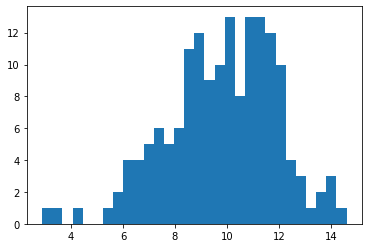

In [327]:
plt.hist(df_train_fortest.groupby("Env")["Yield_Mg_ha"].mean(), bins=30)

In [852]:
pd.read_csv("./submission_f_1.csv")

,Env,Hybrid,Yield_Mg_ha
0,DEH1_2022,B14A/OH43,9.682773
1,DEH1_2022,B37/H95,9.556603
2,DEH1_2022,B73/MO17,10.768375
3,DEH1_2022,B73/PHN82,11.018264
4,DEH1_2022,B73/TX779,9.477677
...,...,...,...
11550,WIH3_2022,W10010_0337/LH244,9.970749
11551,WIH3_2022,W10010_0346/LH244,9.966880
11552,WIH3_2022,W10010_0358/LH244,9.657593
11553,WIH3_2022,W10010_0381/LH244,9.945902
